In [1]:
import requests
from last_fm_secrets import *
import time
import numpy as np
import pandas as pd
import math
from plotly import express as px
import seaborn as sns
from plotly import express as px

pdix = pd.IndexSlice



headers = {
    "user-agent": func_dict.user_agent
}

NameError: name 'func_dict' is not defined

In [5]:
class Function_Dictionary_Class:
    user_agent = "Halcyon"
    api_key    = api_key
    secret     = secret
    api_root_url        = "http://ws.audioscrobbler.com/2.0"
    method              = "user.getRecentTracks"
    user                = username
    json                = "json"
    root_key            = "recenttracks"
    attributes          = "@attr"
    tracks              = "track"
    mb_id               = "mbid"
    artist              = "artist"
    artists             = "artists"
    name                = "name"
    album               = "album"
    date                = "date"
    uts                 = "uts"
    text                = "#text"
    idd                 = "id"
    release_date        = "release_date"
    total_tracks        = "total_tracks"
    duration            = "duration_ms"
    explicit            = "explicit"
    popularity          = "popularity"
    danceability        = "danceability"
    energy              = "energy"
    key                 = "key"
    loudness            = "loudness"
    mode                = "mode"
    speechiness         = "speechiness"
    acousticness        = "acousticness"
    instrumentalness    = "instrumentalness"
    liveness            = "liveness"
    valence             = "valence"
    tempo               = "tempo"
    time_signature      = "time_signature"
    metrics             = ["danceability",
                           "energy", 
                           "key", 
                           "loudness",
                           "mode",
                           "speechiness",
                           "instrumentalness",
                           "acousticness",
                           "liveness",
                           "valence",
                           "tempo",
                           "time_signature"]

    class DataFrame_Columns_Class:
        track_id        = "track_id"
        artist_id       = "artist_id"
        album_id        = "album_id"
        track_name      = "track_name"
        artist_name     = "artist_name"
        album_name      = "album_name"
        date            = "date"
        album_release   = "album_release_date"
        album_tracks    = "album_total_tracks"
        duration        = "track_duration"
        explicit        = "explicit"
        popularity      = "track_popularity"
        track_merge     = "track_name_merge"
        artist_merge    = "artist_name_merge"
    
    def __init__(self):
        self.df_columns = self.DataFrame_Columns_Class()

func_dict = Function_Dictionary_Class()

In [5]:
def retrieve_page(user_name, page):
    #Define the payload we will use
    payload = {
        "api_key":  func_dict.api_key,
        "method":   func_dict.method,
        "format":   func_dict.json,
        "limit":    200,
        "user":     user_name,
        "extended": 1,
        "page":     page
    }

    #Use requests to send the payload to the root URL as a JSON.
    r = requests.get(func_dict.api_root_url, headers=headers, params=payload)
    retrieved_json = r.json()
    
    #Retrieve the attributes from the JSON using the proper keys.
    attributes = retrieved_json[func_dict.root_key][func_dict.attributes]

    #Generate an error if the requested page exceeds the number of total pages returned
    if page > int(attributes['totalPages']):
        raise ValueError("Exceeded total number of pages")
    
    #Return the tracks value from the JSON for processing.
    return retrieved_json[func_dict.root_key][func_dict.tracks]

def parse_page(page_data):
    
    #This temporary list functions to store a list of dictionaries that will then be converted into a DataFrame
    temp_list = []

    #For each entry in the input data, which should be the direct output from the retrieve_page function, add a new item
    #to the list
    for entry in page_data:
        temp_list.append({
            func_dict.df_columns.track_name:    entry[func_dict.name],
            func_dict.df_columns.track_id:      entry[func_dict.mb_id],
            func_dict.df_columns.artist_name:   entry[func_dict.artist][func_dict.name],
            func_dict.df_columns.artist_id:     entry[func_dict.artist][func_dict.mb_id],
            func_dict.df_columns.album_name:    entry[func_dict.album][func_dict.text],
            func_dict.df_columns.album_id:      entry[func_dict.album][func_dict.mb_id],
            func_dict.df_columns.date:          entry[func_dict.date][func_dict.uts]
        })
    
    #Once we're done iterating over the input data, turn it into a dataframe, parse the time column into a pandas datetime
    #given that it is given back as seconds in Unix time, then return the resulting dataframe
    return_df = pd.DataFrame(temp_list)
    return_df[func_dict.df_columns.date] = pd.to_datetime(return_df[func_dict.df_columns.date], unit="s")
    return return_df

In [6]:
def retrieve_all_played_tracks(user_name):

    #Retrieve first page, just for attribute examination
    payload = {
        "api_key": func_dict.api_key,
        "method": func_dict.method,
        "format": func_dict.json,
        "limit": 200,
        "user": user_name,
        "extended": 1,
    }
    r = requests.get(func_dict.api_root_url, headers=headers, params=payload)
    retrieved_json = r.json()
    attributes = retrieved_json[func_dict.root_key][func_dict.attributes]
    total_pages = int(attributes['totalPages'])

    #Sets up a list that will hold the resulting DataFrame from the parse_page function. We will concatenate them all
    #together at the end.
    list_of_dataframes = []

    #Use the retrieved total_pages from the attributes to iterate over each. Can be optimized to not retrieve the first
    #page again, but for brevity of the gist this will just re-request the first page.
    for i in range(total_pages):
        #\r at the beginning is solely for compatibility with VSCode's Python Interactive
        print(f"\rPage {i + 1} of {total_pages}", end="")
        time_start = time.time()
        
        #This will loop on a KeyError since that means we received an empty JSON. This will make it try to retrieve the 
        #failed page again, functionally eliminating the possibility of skipped pages.
        while True:
            try:
                page_data = retrieve_page(user_name, i + 1)
                #If the function gets to this point, break out of the loop and continue
                break
            except KeyError:
                continue
        
        #Parse the page and append it to the list of dataframes, then note how much time was taken for the request to be
        #completed
        list_of_dataframes.append(parse_page(page_data))
        time_taken = time.time() - time_start

        #Debounce the requests to have a maximum of 4 functions per second. This value can be edited to work faster at
        #a heavy risk of getting your API key or IP banned.
        if time_taken < 0.25:
            time.sleep(0.25 - time_taken)
        else:
            continue
    
    #Once all pages have been retrieved, concatenate all the dataframes in the list of dataframes and drop their indices
    #to create a new index. Due to the way the data is formatted and the order of retrieval, this will already be set up
    #time-ascending order, with the first song chronologically at index 0.
    return pd.concat(list_of_dataframes, ignore_index=True)


In [4]:
df = pd.read_hdf("listener_df.h5", key="df", parse_dates="date")

In [5]:
df

track_name                              track_id  \
0                          Can't Help  2e585c77-48e8-420d-9649-28c188e9fc0f   
1                         Canned Heat  045ef838-e886-4155-ad57-116bda32b97b   
2       Beach Bones (Feat. Ryan Ross)                                         
3          Push Push (Lady Lightning)  63aea131-a5f2-41c3-b689-aad85f9c46ec   
4                     Procrastinating  4f90aefc-acda-3807-8ba7-4bb829e1936e   
...                               ...                                   ...   
128343                  Cupid Shuffle  2907feb9-c3b0-4b03-94af-ba2b38e7ae93   
128344                 Out of My Head  21195bf8-14f7-3601-8064-2026d46ffc28   
128345                     Painkiller  039cd1bb-8fc9-3fcc-a902-0af24a1e05cc   
128346                     The Anthem  17e96d04-f759-3125-865e-ec4b19f81ba8   
128347               Bullets and Guns  93d721da-9773-4f55-b9df-8237abe6f8ab   

                artist_name artist_id                              album_name  \
0                 Parachute                                        Can't Help   
1                Jamiroquai                                       Synkronized   
2                 More Amor                     Beach Bones (feat. Ryan Ross)   
3               Bang Camaro                                       Bang Camaro   
4              Stellar Kart            Life Is Good: The Best of Stellar Kart   
...                     ...       ...                                     ...   
128343                Cupid                                 Time For A Change   
128344  Theory of a Deadman                                   The Truth Is...   
128345         Judas Priest                      Judas Priest - The Essential   
128346       Good Charlotte                                        The Anthem   
128347       Them Terribles                            Rock, Paper, Terribles   

                                    album_id                date  
0       75fd3dcb-62e2-4a86-b479-c14903d5f57a 2020-12-17 00:55:08  
1       2ab9c2ba-8026-4f80-ae12-56450b1165fb 2020-12-17 00:49:36  
2                                            2020-12-17 00:46:10  
3       2defe6da-a0d0-419d-83a7-1709e1f3fc62 2020-12-17 00:41:28  
4                                            2020-12-17 00:32:43  
...                                      ...                 ...  
128343  4bbbe6a2-64a9-4550-8c1d-c9590591b4d7 2013-09-07 11:05:10  
128344  4f1279aa-98af-43dd-9b90-8d0d3d00c12d 2013-09-07 11:02:49  
128345                                       2013-09-07 10:56:31  
128346  29b20ee4-d4df-40d6-98da-7c1d229ee1da 2013-09-07 10:53:36  
128347  99b57020-1e36-4bb5-a0ca-2dfad73077d9 2013-09-07 10:51:10  

[128348 rows x 7 columns]

In [6]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.exceptions import SpotifyException

auth_manager = SpotifyClientCredentials(client_id=spotify_key, client_secret=spotify_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [7]:
def parse_tracks(json):
    new_dict = {
        func_dict.df_columns.album_name:    json[func_dict.album][func_dict.name],
        func_dict.df_columns.album_id:      json[func_dict.album][func_dict.idd],
        func_dict.df_columns.album_release: json[func_dict.album][func_dict.release_date],
        func_dict.df_columns.album_tracks:  json[func_dict.album][func_dict.total_tracks],
        func_dict.df_columns.artist_name:   json[func_dict.artists][0][func_dict.name],
        func_dict.df_columns.artist_id:     json[func_dict.artists][0][func_dict.idd],
        func_dict.df_columns.duration:      json[func_dict.duration],
        func_dict.df_columns.track_name:    json[func_dict.name],
        func_dict.df_columns.track_id:      json[func_dict.idd],
        func_dict.df_columns.explicit:      json[func_dict.explicit],
        func_dict.df_columns.popularity:    json[func_dict.popularity]
    }
    return new_dict

def parse_features(json):
    new_dict = {
        func_dict.idd:                          json[func_dict.idd],
        func_dict.danceability:                 json[func_dict.danceability],
        func_dict.energy:                       json[func_dict.energy],
        func_dict.key:                          json[func_dict.key],
        func_dict.loudness:                     json[func_dict.loudness],
        func_dict.mode:                         json[func_dict.mode],
        func_dict.speechiness:                  json[func_dict.speechiness],
        func_dict.instrumentalness:             json[func_dict.instrumentalness],
        func_dict.acousticness:                 json[func_dict.acousticness],
        func_dict.liveness:                     json[func_dict.liveness],
        func_dict.valence:                      json[func_dict.valence],
        func_dict.tempo:                        json[func_dict.tempo],
        func_dict.time_signature:               json[func_dict.time_signature]
    }
    return new_dict

def parse_multiple_features(response_list):
    return_list = []
    
    for track in response_list:
        try:
            return_list.append(parse_features(track))
        except TypeError:
            continue
    
    return pd.DataFrame(return_list)

def parse_multiple_tracks(response_json):
    list_of_tracks = response_json['tracks']
    return_list = []

    for track in list_of_tracks:
        try:
            return_list.append(parse_tracks(track))
        except TypeError:
            continue

    return pd.DataFrame(return_list)

@spotify_call
def retrieve_tracks(id_list):
    return sp.tracks(id_list)

def start_building_db(input_df):

    #Calculate the number of iterations to run for, minus one
    iterations = math.ceil(len(input_df) / 50) - 1
    #Create an empty list that will contain all the dataframes for each iteration called
    dfs = []

    for i in range(iterations):
        #Slice the list of IDs that will be used. This ensures it will only ever be 50 at a time
        id_list = input_df['track_id'][50 * i : 50 * (i + 1)]
        #retrieve the track JSON for the given list of IDs
        try:
            track_json = sp.tracks(id_list)
        except SpotifyException as e:
            #Retrieve the sleep timer from the 'Retry-After' value in the header, sleep for that amount of time, then
            #try again
            sleep_timer = e.headers['Retry-After']
            time.sleep(sleep_timer + .1)
            track_json = sp.tracks(id_list)
        
        #Parse the resulting JSON
        track_df = parse_multiple_tracks(track_json)

        #Do the exact same but for features
        try:
            feature_json = sp.audio_features(id_list)
        except SpotifyException as e:
            sleep_timer = e.headers['Retry-After']
            time.sleep(sleep_timer + .1)
            feature_json = sp.audio_features(id_list)

        feature_df = parse_multiple_features(feature_json)

        #Merge the two dataframes, using an inner merge to kick out any tracks which would have incomplete information
        merged_df = track_df.merge(feature_df, how="inner", left_on="track_id", right_on="id")

        dfs.append(merged_df)
    
    #Repeat the above process but for the final tracks, which can be up to 50. NOTE: THIS WILL CREATE DUPLICATES. THAT IS FINE
    final_tracks = input_df['track_id'][-50:]
    try:
        return_json = sp.tracks(final_tracks)
    except SpotifyException as e:
        sleep_timer = e.headers['Retry-After']
        time.sleep(sleep_timer + .1)
        return_json = sp.tracks(final_tracks)

    track_df = parse_multiple_tracks(return_json)

    try:
        feature_json = sp.audio_features(final_tracks)
    except SpotifyException as e:
        sleep_timer = e.headers['Retry-After']
        time.sleep(sleep_timer + .1)
        feature_json = sp.audio_features(final_tracks)

    feature_df = parse_multiple_features(feature_json)

    merged_df = track_df.merge(feature_df, how="inner", left_on="track_id", right_on="id")
    dfs.append(merged_df)

    #Concatenate all the dataframes, ignore the index, and drop duplicates created in the last step
    return pd.concat(dfs, ignore_index=True).drop_duplicates(keep="first").reset_index(drop=True)


NameError: name 'spotify_call' is not defined

In [26]:
initial_song_list = pd.read_clipboard(header=None)
# initial_song_list[func_dict.df_columns.track_id] = initial_song_list[0].str[31:]
# initial_song_list = initial_song_list[[func_dict.df_columns.track_id]]

In [27]:
initial_song_list

0
0     https://open.spotify.com/track/4YeKAwFn69ehnci...
1     https://open.spotify.com/track/1PjGQJZWkh4FLkH...
2     https://open.spotify.com/track/53AuxddsgPSlqM6...
3     https://open.spotify.com/track/3uPfVXcjnpOjyzI...
4     https://open.spotify.com/track/21jGcNKet2qwijl...
...                                                 ...
3065  https://open.spotify.com/track/6GrvXORJUCRc9W0...
3066  https://open.spotify.com/track/08CGnqCGoDPowDK...
3067  https://open.spotify.com/track/4X71IgEyCwAOXKY...
3068  https://open.spotify.com/track/2bv7c5HdHL6BrlJ...
3069  https://open.spotify.com/track/2BBEDn2ODggSwnE...

[3070 rows x 1 columns]

In [25]:
initial_song_list

track_id
0     4YeKAwFn69ehnciOfi7Sbf
1     1PjGQJZWkh4FLkH1UKzytl
2     53AuxddsgPSlqM619nJhSd
3     3uPfVXcjnpOjyzI3jb3js4
4     21jGcNKet2qwijlDFuPiPb
...                      ...
3065  6GrvXORJUCRc9W0onkjiGS
3066  08CGnqCGoDPowDKNTLWisO
3067  4X71IgEyCwAOXKYGYjxriy
3068  2bv7c5HdHL6BrlJt1ASAbc
3069  2BBEDn2ODggSwnETkJfGB3

[3070 rows x 1 columns]

In [22]:
initial_spotify_df = start_building_db(initial_song_list.loc[~initial_song_list['track_id'].str.contains("%20")])

Expected id of type track but found type Holiday Jakubi//Holiday/224
Expected id of type track but found type Holiday Jakubi//Holiday/224
Expected id of type track but found type Spoonman Soundgarden/Superunknown/Spoonman/246
Expected id of type track but found type Spoonman Soundgarden/Superunknown/Spoonman/246


In [23]:
initial_spotify_df

album_name                album_id  \
0                                   Conquest  7wZkqIpYypNxkR93nDucc5   
1                                  Armistice  3YmsWfVb0BTohLarAlbgFY   
2                         Save Rock And Roll  0EVJX4RlYKuApsAN5CaDa3   
3                                    Floored  3jMUfZpBUTZOl91khbj4ic   
4                       Hollywood's Bleeding  4g1ZRSobMefqF6nelkgibi   
...                                      ...                     ...   
3004                      All Out Everything  3cp10tepg2crOCBO4DYsEe   
3005                       It's Only Natural  5bGGtzhY8JtVuv5TTbiDFJ   
3006  Recoil (Explicit Content U.S. Version)  0wMl72AddFnnhtCVNyWx2G   
3007                  Race You to the Bottom  13eNs79hvWC8FB96ekbAVy   
3008                            Just Say Yes  5YgnsSqMx9PkwOXjptc7gb   

     album_release_date  album_total_tracks   artist_name  \
0            2009-01-01                  11        Madcon   
1            2009-07-31                  12      Mutemath   
2            2013-01-01                  11  Fall Out Boy   
3            1997-06-20                  13     Sugar Ray   
4            2019-09-06                  17   Post Malone   
...                 ...                 ...           ...   
3004         2010-12-11                  10       All Out   
3005         2009-06-19                  12    The Higher   
3006         2004-07-13                  14      Nonpoint   
3007         2010-09-28                  15  New Medicine   
3008         2008-09-16                  12     Punchline   

                   artist_id  track_duration             track_name  \
0     6c4sUNBgdonFJz8Kx2VsGz          218706                Beggin'   
1     1J9Z9bhqkgyqseEi85cbyx          228586              Electrify   
2     4UXqAaa6dQYAk18Lv7PEgX          244960            The Phoenix   
3     4uN3DsfENc7dp0OLO0FEIb          244134                    Fly   
4     246dkjvS1zLTtiykXe5h60          215280                Circles   
...                      ...             ...                    ...   
3004  3Q9iaulvh7rGoY0H56dXKA          205903          Lights Ft. XV   
3005  6hALa9u5I9KY2PLC2rzsLE          194813      It's Only Natural   
3006  6BdSOHfQ6kMg0tbAFlXR1z          173306           Broken Bones   
3007  3driPpCh1JEUnPFKGyHXDr          152253           The Takeover   
3008  1CK7niAEBeKXci8KtBvxbG          178600  Somewhere In The Dark   

                    track_id  explicit  ...  key loudness  mode  speechiness  \
0     4YeKAwFn69ehnciOfi7Sbf     False  ...    4   -4.889     0       0.0534   
1     1PjGQJZWkh4FLkH1UKzytl     False  ...    4   -4.102     0       0.2200   
2     53AuxddsgPSlqM619nJhSd     False  ...    4   -2.991     0       0.0720   
3     3uPfVXcjnpOjyzI3jb3js4     False  ...    1   -8.150     1       0.0488   
4     21jGcNKet2qwijlDFuPiPb     False  ...    0   -3.497     1       0.0395   
...                      ...       ...  ...  ...      ...   ...          ...   
3004  6GrvXORJUCRc9W0onkjiGS      True  ...    0   -5.441     1       0.4320   
3005  08CGnqCGoDPowDKNTLWisO     False  ...    8   -3.279     0       0.0688   
3006  4X71IgEyCwAOXKYGYjxriy     False  ...    5   -3.638     0       0.0676   
3007  2bv7c5HdHL6BrlJt1ASAbc      True  ...    3   -3.424     0       0.0593   
3008  2BBEDn2ODggSwnETkJfGB3     False  ...    0   -3.480     1       0.0324   

      instrumentalness  acousticness  liveness  valence    tempo  \
0             0.000000      0.028400    0.0658    0.431  129.040   
1             0.000000      0.000122    0.3850    0.367  175.055   
2             0.000002      0.000539    0.5790    0.410  138.063   
3             0.225000      0.020200    0.3080    0.674   99.701   
4             0.002440      0.192000    0.0863    0.553  120.042   
...                ...           ...       ...      ...      ...   
3004          0.000000      0.040300    0.2070    0.620  158.093   
3005          0.001370      0.027900    0.0537    0.787  120.021   
3006      

In [24]:
initial_spotify_df

album_name                album_id  \
0                                   Conquest  7wZkqIpYypNxkR93nDucc5   
1                                  Armistice  3YmsWfVb0BTohLarAlbgFY   
2                         Save Rock And Roll  0EVJX4RlYKuApsAN5CaDa3   
3                                    Floored  3jMUfZpBUTZOl91khbj4ic   
4                       Hollywood's Bleeding  4g1ZRSobMefqF6nelkgibi   
...                                      ...                     ...   
3004                      All Out Everything  3cp10tepg2crOCBO4DYsEe   
3005                       It's Only Natural  5bGGtzhY8JtVuv5TTbiDFJ   
3006  Recoil (Explicit Content U.S. Version)  0wMl72AddFnnhtCVNyWx2G   
3007                  Race You to the Bottom  13eNs79hvWC8FB96ekbAVy   
3008                            Just Say Yes  5YgnsSqMx9PkwOXjptc7gb   

     album_release_date  album_total_tracks   artist_name  \
0            2009-01-01                  11        Madcon   
1            2009-07-31                  12      Mutemath   
2            2013-01-01                  11  Fall Out Boy   
3            1997-06-20                  13     Sugar Ray   
4            2019-09-06                  17   Post Malone   
...                 ...                 ...           ...   
3004         2010-12-11                  10       All Out   
3005         2009-06-19                  12    The Higher   
3006         2004-07-13                  14      Nonpoint   
3007         2010-09-28                  15  New Medicine   
3008         2008-09-16                  12     Punchline   

                   artist_id  track_duration             track_name  \
0     6c4sUNBgdonFJz8Kx2VsGz          218706                Beggin'   
1     1J9Z9bhqkgyqseEi85cbyx          228586              Electrify   
2     4UXqAaa6dQYAk18Lv7PEgX          244960            The Phoenix   
3     4uN3DsfENc7dp0OLO0FEIb          244134                    Fly   
4     246dkjvS1zLTtiykXe5h60          215280                Circles   
...                      ...             ...                    ...   
3004  3Q9iaulvh7rGoY0H56dXKA          205903          Lights Ft. XV   
3005  6hALa9u5I9KY2PLC2rzsLE          194813      It's Only Natural   
3006  6BdSOHfQ6kMg0tbAFlXR1z          173306           Broken Bones   
3007  3driPpCh1JEUnPFKGyHXDr          152253           The Takeover   
3008  1CK7niAEBeKXci8KtBvxbG          178600  Somewhere In The Dark   

                    track_id  explicit  ...  key loudness  mode  speechiness  \
0     4YeKAwFn69ehnciOfi7Sbf     False  ...    4   -4.889     0       0.0534   
1     1PjGQJZWkh4FLkH1UKzytl     False  ...    4   -4.102     0       0.2200   
2     53AuxddsgPSlqM619nJhSd     False  ...    4   -2.991     0       0.0720   
3     3uPfVXcjnpOjyzI3jb3js4     False  ...    1   -8.150     1       0.0488   
4     21jGcNKet2qwijlDFuPiPb     False  ...    0   -3.497     1       0.0395   
...                      ...       ...  ...  ...      ...   ...          ...   
3004  6GrvXORJUCRc9W0onkjiGS      True  ...    0   -5.441     1       0.4320   
3005  08CGnqCGoDPowDKNTLWisO     False  ...    8   -3.279     0       0.0688   
3006  4X71IgEyCwAOXKYGYjxriy     False  ...    5   -3.638     0       0.0676   
3007  2bv7c5HdHL6BrlJt1ASAbc      True  ...    3   -3.424     0       0.0593   
3008  2BBEDn2ODggSwnETkJfGB3     False  ...    0   -3.480     1       0.0324   

      instrumentalness  acousticness  liveness  valence    tempo  \
0             0.000000      0.028400    0.0658    0.431  129.040   
1             0.000000      0.000122    0.3850    0.367  175.055   
2             0.000002      0.000539    0.5790    0.410  138.063   
3             0.225000      0.020200    0.3080    0.674   99.701   
4             0.002440      0.192000    0.0863    0.553  120.042   
...                ...           ...       ...      ...      ...   
3004          0.000000      0.040300    0.2070    0.620  158.093   
3005          0.001370      0.027900    0.0537    0.787  120.021   
3006      

In [35]:
initial_merge = df[["track_name", "artist_name", "date"]].merge(initial_spotify_df.drop_duplicates(), how="left", on=[func_dict.df_columns.track_name, func_dict.df_columns.artist_name])
initial_merge

track_name     artist_name                date  \
0                          Can't Help       Parachute 2020-12-17 00:55:08   
1                         Canned Heat      Jamiroquai 2020-12-17 00:49:36   
2       Beach Bones (Feat. Ryan Ross)       More Amor 2020-12-17 00:46:10   
3          Push Push (Lady Lightning)     Bang Camaro 2020-12-17 00:41:28   
4                     Procrastinating    Stellar Kart 2020-12-17 00:32:43   
...                               ...             ...                 ...   
144520                     Painkiller    Judas Priest 2013-09-07 10:56:31   
144521                     The Anthem  Good Charlotte 2013-09-07 10:53:36   
144522                     The Anthem  Good Charlotte 2013-09-07 10:53:36   
144523                     The Anthem  Good Charlotte 2013-09-07 10:53:36   
144524               Bullets and Guns  Them Terribles 2013-09-07 10:51:10   

                          album_name                album_id  \
0                         Can't Help  0Fy31rd6aBdfrF3M4N09rb   
1                        Synkronized  0rfXEWU67NngRYE58q1aMO   
2                                NaN                     NaN   
3                        Bang Camaro  2EW0qzRe2ntiYBerUAgJqr   
4        We Can't Stand Sitting Down  4E3hrnhsgHifQlL83tu57M   
...                              ...                     ...   
144520  Judas Priest - The Essential  634f0ThTo5tINAaRuCp0Bk   
144521    The Young and The Hopeless  5CTygC3aONv7l0klY4k3hc   
144522                 Greatest Hits  02abrECBsxdR3Ywjy1hCuW   
144523                    The Anthem  2kwzEA1chuNvpOeORDkqNs   
144524        Rock, Paper, Terribles  3Nc9E7ZKx8WqGqUbNRuV3r   

       album_release_date  album_total_tracks               artist_id  \
0              2013-01-01                 1.0  2PCUhxD40qlMqsKHjTZD2e   
1              1999-06-08                10.0  6J7biCazzYhU3gM9j1wfid   
2                     NaN                 NaN                     NaN   
3              2007-01-01                12.0  7sB9Netl8x6rYTw0gs1JJ8   
4              2006-07-25                13.0  5WM2QZxPsbSfFrt4ibSDBi   
...                   ...                 ...                     ...   
144520               2005                34.0  2tRsMl4eGxwoNabM08Dm4I   
144521         2002-10-04                14.0  5aYyPjAsLj7UzANzdupwnS   
144522         2010-11-12                16.0  5aYyPjAsLj7UzANzdupwnS   
144523               2003                 2.0  5aYyPjAsLj7UzANzdupwnS   
144524         2007-01-01                 7.0  0tbl2QOP1YWZKc6VWR77ot   

        track_duration                track_id  ...   key  loudness mode  \
0             204506.0  3PkqKXtkXUffwiGs6H6K71  ...  10.0    -3.480  0.0   
1             331733.0  2u5woInaGB7YASEd1CwGBJ  ...   5.0    -5.821  1.0   
2                  NaN                     NaN  ...   NaN       NaN  NaN   
3             281653.0  02YuWD3sBOJa1cnGW1DqCE  ...   9.0    -7.097  0.0   
4             161320.0  2ca7DN6Edo42tuY2rTPwRk  ...  11.0    -3.343  1.0   
...                ...                     ...  ...   ...       ...  ...   
144520        365680.0  5z7Gr22ByWTRnWP39M7Hj1  ...   1.0    -4.902  0.0   
144521        175093.0  0BRHnOFm6sjxN1i9LJrUDu  ...   1.0    -3.127  1.0   
144522        174213.0  63t9x6MyYnZ9tYprnk6cty  ...   1.0    -3.078  1.0   
144523        174000.0  6sSJMwvxWRXkEcRv1WW1Gx  ...   1.0    -3.120  1.0   
144524        147066.0  0JwqL8VBK4Ooma13Pw2TUs  ...   5.0    -4.419  0.0   

        speechiness  instrumentalness  acousticness  liveness  valence  \
0            0.0414          0.000000      0.001950    0.0819   0.7660   
1            0.1250          0.000207      0.013100    0.0751   0.7730   
2               NaN               NaN           NaN       NaN      NaN   
3            0.0948          0.005070      0.001710    0.0630   0.4010   
4            0.0424          0.000000      0.000066    0.3930   0.7130   
...             ...               ...           ...       ...      ...   
144520       0.1720      

In [31]:
deduped_spotify_df = initial_spotify_df.sort_values(func_dict.df_columns.album_release).groupby([func_dict.df_columns.track_name, func_dict.df_columns.artist_name]).first().reset_index()

In [32]:
deduped_spotify_df

track_name             artist_name  \
0     "The Take Over, The Breaks Over"            Fall Out Boy   
1                              #SELFIE        The Chainsmokers   
2                    'Till I Get There             Lupe Fiasco   
3              (Don't Fear) The Reaper        Blue Öyster Cult   
4               (Fuck A) Silver Lining     Panic! At The Disco   
...                                ...                     ...   
2737                         push pull             Purity Ring   
2738                          rockstar             Post Malone   
2739                      take me home  After Midnight Project   
2740                     thank u, next           Ariana Grande   
2741                     younger women                  VÉRITÉ   

                          album_name                album_id  \
0                   Infinity On High  0hHopYqXhuvYSHtVyrcb1g   
1                            #SELFIE  3OeA4rJ9XJNAygyNyTc2sI   
2                             Lasers  4Um8wMKUXteqtUlFelOHrg   
3     The Essential Blue Öyster Cult  6NNrQJ8ojvbfFzoUjjABo4   
4        Say Amen for Silver Linings  2AzBM2be7dJEhOKJBP9FYR   
...                              ...                     ...   
2737                       push pull  4towtAU3ilQhDVA5Ink2KN   
2738                        rockstar  1YCRXKLDRB0UnbrFUJ4F6e   
2739          After Midnight Project  2AMnEB6MQmgzkq6jy7G6nj   
2740                   thank u, next  684W6NpKllEexqQlGqetCi   
2741              new limbs (vol. 1)  6MESAvZKy3Alr15vDizZmU   

     album_release_date  album_total_tracks               artist_id  \
0            2007-01-01                  19  4UXqAaa6dQYAk18Lv7PEgX   
1            2014-01-01                   1  69GGBxA162lTqCwzJG5jLp   
2            2011-03-07                  12  01QTIT5P1pFP3QnnFSdsJf   
3                  1972                  14  00tVTdpEhQQw1bqdu8RCx2   
4            2018-03-21                   2  20JZFwl6HVl6yg8a4H3ZqK   
...                 ...                 ...                     ...   
2737         2014-12-04                   1  1TtJ8j22Roc24e2Jx3OcU4   
2738         2017-09-15                   1  246dkjvS1zLTtiykXe5h60   
2739         2006-07-25                   5  1CCtRpOlg6EL0HP9DdEtk4   
2740         2018-11-03                   1  66CXWjxzNUsdJxJ2JdwvnR   
2741         2020-10-09                   4  1Fr6agZ6iSM5Ynn2k4C8sc   

      track_duration                track_id  explicit  ...  key loudness  \
0             213586  3rG8ZkmKHb4Ms6CsSzEITv     False  ...    9   -2.563   
1             183750  1HOlb9rdNOmy9b1Fakicjo     False  ...    0   -3.262   
2             203973  4MZTeIw3uRaBB2BiuVKFv6     False  ...    1   -6.427   
3             308640  2NL4BBBSgypHnxUKmQdYcT     False  ...    0   -8.349   
4             168613  7g58rb2dFDCvcmLBwpHR9F      True  ...    1   -1.352   
...              ...                     ...       ...  ...  ...      ...   
2737          207809  223pTIXzqcuxzQyAtz5kyo     False  ...    5   -8.173   
2738          218320  1OmcAT5Y8eg5bUPv9qJT4R      True  ...    5   -6.631   
2739          242560  6rB6HeqN515Hn2BAjz2m3I     False  ...    7   -4.744   
2740          207333  2rPE9A1vEgShuZxxzR2tZH      True  ...    1   -5.642   
2741          276356  021MoAgWlZzGFsYzjeQ70Q      True  ...    6   -9.810   

      mode  speechiness  instrumentalness  acousticness  liveness  valence  \
0        1       0.0477          0.000020       0.00614    0.0775   0.6700   
1        1       0.2490          0.000008       0.01350    0.0770   0.6580   
2        1       0.0465          0.000023       0.02370    0.1180   0.7820   
3        1       0.0609          0.002130       0.00127    0.3050   0.5590   
4        0       0.1080          0.000000       0.02720    0.2400   0.7140   
...    ...          ...               ...           ...       ...      ...   
2737     1       0.0489          0.000023       0.00287    0.2450   0.0858   
2738     0       0.0776          0.000127       0.12800    0.143

In [34]:
second_merge = df[["track_name", "artist_name", "date"]].merge(deduped_spotify_df.drop_duplicates(), how="left", on=[func_dict.df_columns.track_name, func_dict.df_columns.artist_name])
second_merge

track_name          artist_name  \
0                          Can't Help            Parachute   
1                         Canned Heat           Jamiroquai   
2       Beach Bones (Feat. Ryan Ross)            More Amor   
3          Push Push (Lady Lightning)          Bang Camaro   
4                     Procrastinating         Stellar Kart   
...                               ...                  ...   
128343                  Cupid Shuffle                Cupid   
128344                 Out of My Head  Theory of a Deadman   
128345                     Painkiller         Judas Priest   
128346                     The Anthem       Good Charlotte   
128347               Bullets and Guns       Them Terribles   

                      date                         album_name  \
0      2020-12-17 00:55:08                         Can't Help   
1      2020-12-17 00:49:36                        Synkronized   
2      2020-12-17 00:46:10                                NaN   
3      2020-12-17 00:41:28                        Bang Camaro   
4      2020-12-17 00:32:43        We Can't Stand Sitting Down   
...                    ...                                ...   
128343 2013-09-07 11:05:10                  Time For A Change   
128344 2013-09-07 11:02:49  The Truth Is... (Special Edition)   
128345 2013-09-07 10:56:31                         Painkiller   
128346 2013-09-07 10:53:36         The Young and The Hopeless   
128347 2013-09-07 10:51:10             Rock, Paper, Terribles   

                      album_id album_release_date  album_total_tracks  \
0       0Fy31rd6aBdfrF3M4N09rb         2013-01-01                 1.0   
1       0rfXEWU67NngRYE58q1aMO         1999-06-08                10.0   
2                          NaN                NaN                 NaN   
3       2EW0qzRe2ntiYBerUAgJqr         2007-01-01                12.0   
4       4E3hrnhsgHifQlL83tu57M         2006-07-25                13.0   
...                        ...                ...                 ...   
128343  1tDyAU95D65Shy34JxsQCu         2007-09-11                12.0   
128344  2JUpjRRxWKUZwVwY9sTXS1         2011-07-08                18.0   
128345  7LgrhuKnAXpNEv8qzcVd2t         1990-09-26                12.0   
128346  5CTygC3aONv7l0klY4k3hc         2002-10-04                14.0   
128347  3Nc9E7ZKx8WqGqUbNRuV3r         2007-01-01                 7.0   

                     artist_id  track_duration                track_id  ...  \
0       2PCUhxD40qlMqsKHjTZD2e        204506.0  3PkqKXtkXUffwiGs6H6K71  ...   
1       6J7biCazzYhU3gM9j1wfid        331733.0  2u5woInaGB7YASEd1CwGBJ  ...   
2                          NaN             NaN                     NaN  ...   
3       7sB9Netl8x6rYTw0gs1JJ8        281653.0  02YuWD3sBOJa1cnGW1DqCE  ...   
4       5WM2QZxPsbSfFrt4ibSDBi        161320.0  2ca7DN6Edo42tuY2rTPwRk  ...   
...                        ...             ...                     ...  ...   
128343  0lax1ZgWclW6mZFaGu27MM        231360.0  07Tx168RSsUS1HqkDIOZbH  ...   
128344  74eX4C98E4FCrAMl39qRsJ        237786.0  6JGsVW1nxNaoUAGcOKFZGS  ...   
128345  2tRsMl4eGxwoNabM08Dm4I        365826.0  0L7zm6afBEtrNKo6C6Gj08  ...   
128346  5aYyPjAsLj7UzANzdupwnS        175093.0  0BRHnOFm6sjxN1i9LJrUDu  ...   
128347  0tbl2QOP1YWZKc6VWR77ot        147066.0  0JwqL8VBK4Ooma13Pw2TUs  ...   

         key  loudness mode  speechiness  instrumentalness  acousticness  \
0       10.0    -3.480  0.0       0.0414          0.000000      0.001950   
1        5.0    -5.821  1.0       0.1250          0.000207      0.013100   
2        NaN       NaN  NaN          NaN               NaN           NaN   
3        9.0    -7.097  0.0       0.0948          0.005070      0.001710   
4       11.0    -3.343  1.0       0.0424          0.000000      0.000066   
...      ...       ...  ...          ...               ...           ...   
128343   5.0    -4.877  0.0       0.2370          0.000000      0.191000   
128344  11.0    -3.971  1.0       0.0354          0.000000      0.0

In [36]:
second_merge.loc[second_merge['track_id'].isna()]

track_name     artist_name  \
2                 Beach Bones (Feat. Ryan Ross)       More Amor   
9                                  No Swinggity       Minimatic   
16                                    Heartbeat          Vérité   
20                       Playing the Blame Game   You Me at Six   
24                 The Night Out (Madeon Remix)  Martin Solveig   
...                                         ...             ...   
128333  DJ Got Us Fallin' In Love (Ft. Pitbull)           Usher   
128334                              In the Dark             Dev   
128339        Everybody Wants to Rule the World   JamisonParker   
128340             Rebel Yell - 1999 - Remaster      Billy Idol   
128342                               Absolutely       Nine Days   

                      date album_name album_id album_release_date  \
2      2020-12-17 00:46:10        NaN      NaN                NaN   
9      2020-12-16 23:03:34        NaN      NaN                NaN   
16     2020-12-16 22:39:33        NaN      NaN                NaN   
20     2020-12-16 22:23:59        NaN      NaN                NaN   
24     2020-12-16 22:10:07        NaN      NaN                NaN   
...                    ...        ...      ...                ...   
128333 2013-09-07 12:02:59        NaN      NaN                NaN   
128334 2013-09-07 11:59:10        NaN      NaN                NaN   
128339 2013-09-07 11:40:12        NaN      NaN                NaN   
128340 2013-09-07 11:34:17        NaN      NaN                NaN   
128342 2013-09-07 11:26:48        NaN      NaN                NaN   

        album_total_tracks artist_id  track_duration track_id  ... key  \
2                      NaN       NaN             NaN      NaN  ... NaN   
9                      NaN       NaN             NaN      NaN  ... NaN   
16                     NaN       NaN             NaN      NaN  ... NaN   
20                     NaN       NaN             NaN      NaN  ... NaN   
24                     NaN       NaN             NaN      NaN  ... NaN   
...                    ...       ...             ...      ...  ...  ..   
128333                 NaN       NaN             NaN      NaN  ... NaN   
128334                 NaN       NaN             NaN      NaN  ... NaN   
128339                 NaN       NaN             NaN      NaN  ... NaN   
128340                 NaN       NaN             NaN      NaN  ... NaN   
128342                 NaN       NaN             NaN      NaN  ... NaN   

        loudness mode  speechiness  instrumentalness  acousticness  liveness  \
2            NaN  NaN          NaN               NaN           NaN       NaN   
9            NaN  NaN          NaN               NaN           NaN       NaN   
16           NaN  NaN          NaN               NaN           NaN       NaN   
20           NaN  NaN          NaN               NaN           NaN       NaN   
24           NaN  NaN          NaN               NaN           NaN       NaN   
...          ...  ...          ...               ...           ...       ...   
128333       NaN  NaN          NaN               NaN           NaN       NaN   
128334       NaN  NaN          NaN               NaN           NaN       NaN   
128339       NaN  NaN          NaN               NaN           NaN       NaN   
128340       NaN  NaN          NaN               NaN           NaN       NaN   
128342       NaN  NaN          NaN               NaN           NaN       NaN   

        valence  tempo  time_signature  
2           NaN    NaN             NaN  
9           NaN    NaN             NaN  
16          NaN    NaN             NaN  
20          NaN    NaN             NaN  
24          NaN    NaN             NaN  
...         ...    ...             ...  
128333      NaN    NaN             NaN  
128334      NaN    NaN             NaN  
128339      NaN    NaN             NaN  
128340      NaN    NaN             NaN  
128342      NaN    NaN             NaN  

[40248 rows x 25 columns]

In [52]:
deduped_spotify_df[['track_name_merge', 'artist_name_merge']] = deduped_spotify_df[['track_name', 'artist_name']].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.lower().str.replace(r"\W",''))

In [53]:
deduped_spotify_df

track_name             artist_name  \
0     "The Take Over, The Breaks Over"            Fall Out Boy   
1                              #SELFIE        The Chainsmokers   
2                    'Till I Get There             Lupe Fiasco   
3              (Don't Fear) The Reaper        Blue Öyster Cult   
4               (Fuck A) Silver Lining     Panic! At The Disco   
...                                ...                     ...   
2737                         push pull             Purity Ring   
2738                          rockstar             Post Malone   
2739                      take me home  After Midnight Project   
2740                     thank u, next           Ariana Grande   
2741                     younger women                  VÉRITÉ   

                          album_name                album_id  \
0                   Infinity On High  0hHopYqXhuvYSHtVyrcb1g   
1                            #SELFIE  3OeA4rJ9XJNAygyNyTc2sI   
2                             Lasers  4Um8wMKUXteqtUlFelOHrg   
3     The Essential Blue Öyster Cult  6NNrQJ8ojvbfFzoUjjABo4   
4        Say Amen for Silver Linings  2AzBM2be7dJEhOKJBP9FYR   
...                              ...                     ...   
2737                       push pull  4towtAU3ilQhDVA5Ink2KN   
2738                        rockstar  1YCRXKLDRB0UnbrFUJ4F6e   
2739          After Midnight Project  2AMnEB6MQmgzkq6jy7G6nj   
2740                   thank u, next  684W6NpKllEexqQlGqetCi   
2741              new limbs (vol. 1)  6MESAvZKy3Alr15vDizZmU   

     album_release_date  album_total_tracks               artist_id  \
0            2007-01-01                  19  4UXqAaa6dQYAk18Lv7PEgX   
1            2014-01-01                   1  69GGBxA162lTqCwzJG5jLp   
2            2011-03-07                  12  01QTIT5P1pFP3QnnFSdsJf   
3                  1972                  14  00tVTdpEhQQw1bqdu8RCx2   
4            2018-03-21                   2  20JZFwl6HVl6yg8a4H3ZqK   
...                 ...                 ...                     ...   
2737         2014-12-04                   1  1TtJ8j22Roc24e2Jx3OcU4   
2738         2017-09-15                   1  246dkjvS1zLTtiykXe5h60   
2739         2006-07-25                   5  1CCtRpOlg6EL0HP9DdEtk4   
2740         2018-11-03                   1  66CXWjxzNUsdJxJ2JdwvnR   
2741         2020-10-09                   4  1Fr6agZ6iSM5Ynn2k4C8sc   

      track_duration                track_id  explicit  ...  mode speechiness  \
0             213586  3rG8ZkmKHb4Ms6CsSzEITv     False  ...     1      0.0477   
1             183750  1HOlb9rdNOmy9b1Fakicjo     False  ...     1      0.2490   
2             203973  4MZTeIw3uRaBB2BiuVKFv6     False  ...     1      0.0465   
3             308640  2NL4BBBSgypHnxUKmQdYcT     False  ...     1      0.0609   
4             168613  7g58rb2dFDCvcmLBwpHR9F      True  ...     0      0.1080   
...              ...                     ...       ...  ...   ...         ...   
2737          207809  223pTIXzqcuxzQyAtz5kyo     False  ...     1      0.0489   
2738          218320  1OmcAT5Y8eg5bUPv9qJT4R      True  ...     0      0.0776   
2739          242560  6rB6HeqN515Hn2BAjz2m3I     False  ...     1      0.0900   
2740          207333  2rPE9A1vEgShuZxxzR2tZH      True  ...     1      0.0658   
2741          276356  021MoAgWlZzGFsYzjeQ70Q      True  ...     0      0.0502   

      instrumentalness  acousticness  liveness  valence    tempo  \
0             0.000020       0.00614    0.0775   0.6700  149.948   
1             0.000008       0.01350    0.0770   0.6580  127.956   
2             0.000023       0.02370    0.1180   0.7820   87.008   
3             0.002130       0.00127    0.3050   0.5590  141.162   
4             0.000000       0.02720    0.2400   0.7140  105.092   
...                ...           ...       ...      ...      ...   
2737          0.000023       0.00287    0.2450   0.0858  110.354   
2738          0.000127       0.12800    0.1430   0.1410  159.786   
2739          0.000015      

In [62]:
merge_columns = [func_dict.df_columns.track_merge, func_dict.df_columns.artist_merge]
on_columns =    [func_dict.df_columns.track_name,  func_dict.df_columns.artist_name ]

In [66]:
deduped_spotify_df = deduped_spotify_df.sort_values('album_release_date').groupby(merge_columns).first().reset_index()

In [166]:
df_copy[['track_name_merge', 'artist_name_merge']] = df_copy[['track_name', 'artist_name']].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.lower().str.replace(r"\W",''))

In [167]:
third_merge = df_copy[['track_name', 'artist_name', 'track_name_merge', 'artist_name_merge', 'date']].merge(deduped_spotify_df, how="left", on=merge_columns)
third_merge

track_name_x        artist_name_x  \
0                          Can't Help            Parachute   
1                         Canned Heat           Jamiroquai   
2       Beach Bones (Feat. Ryan Ross)            More Amor   
3          Push Push (Lady Lightning)          Bang Camaro   
4                     Procrastinating         Stellar Kart   
...                               ...                  ...   
128343                  Cupid Shuffle                Cupid   
128344                 Out of My Head  Theory of a Deadman   
128345                     Painkiller         Judas Priest   
128346                     The Anthem       Good Charlotte   
128347               Bullets and Guns       Them Terribles   

              track_name_merge artist_name_merge                date  \
0                     canthelp         parachute 2020-12-17 00:55:08   
1                   cannedheat        jamiroquai 2020-12-17 00:49:36   
2       beachbonesfeatryanross          moreamor 2020-12-17 00:46:10   
3        pushpushladylightning        bangcamaro 2020-12-17 00:41:28   
4              procrastinating       stellarkart 2020-12-17 00:32:43   
...                        ...               ...                 ...   
128343            cupidshuffle             cupid 2013-09-07 11:05:10   
128344             outofmyhead  theoryofadeadman 2013-09-07 11:02:49   
128345              painkiller       judaspriest 2013-09-07 10:56:31   
128346               theanthem     goodcharlotte 2013-09-07 10:53:36   
128347          bulletsandguns     themterribles 2013-09-07 10:51:10   

                         track_name_y        artist_name_y  \
0                          Can't Help            Parachute   
1                         Canned Heat           Jamiroquai   
2       Beach Bones (feat. Ryan Ross)            More Amor   
3          Push Push (Lady Lightning)          Bang Camaro   
4                     Procrastinating         Stellar Kart   
...                               ...                  ...   
128343                  Cupid Shuffle                Cupid   
128344                 Out of My Head  Theory of a Deadman   
128345                     Painkiller         Judas Priest   
128346                     The Anthem       Good Charlotte   
128347               Bullets and Guns       Them Terribles   

                               album_name                album_id  \
0                              Can't Help  0Fy31rd6aBdfrF3M4N09rb   
1                             Synkronized  0rfXEWU67NngRYE58q1aMO   
2           Beach Bones (feat. Ryan Ross)  2yIHW7YYYhWBihGAQ984aI   
3                             Bang Camaro  2EW0qzRe2ntiYBerUAgJqr   
4             We Can't Stand Sitting Down  4E3hrnhsgHifQlL83tu57M   
...                                   ...                     ...   
128343                  Time For A Change  1tDyAU95D65Shy34JxsQCu   
128344  The Truth Is... (Special Edition)  2JUpjRRxWKUZwVwY9sTXS1   
128345                         Painkiller  7LgrhuKnAXpNEv8qzcVd2t   
128346         The Young and The Hopeless  5CTygC3aONv7l0klY4k3hc   
128347             Rock, Paper, Terribles  3Nc9E7ZKx8WqGqUbNRuV3r   

       album_release_date  ...   key loudness  mode speechiness  \
0              2013-01-01  ...  10.0   -3.480   0.0      0.0414   
1              1999-06-08  ...   5.0   -5.821   1.0      0.1250   
2              2012-07-01  ...   6.0   -5.473   0.0      0.0337   
3              2007-01-01  ...   9.0   -7.097   0.0      0.0948   
4              2006-07-25  ...  11.0   -3.343   1.0      0.0424   
...                   ...  ...   ...      ...   ...         ...   
128343         2007-09-11  ...   5.0   -4.877   0.0      0.2370   
128344         2011-07-08  ...  11.0   -3.971   1.0      0.0354   
128345         1990-09-26  ...   1.0   -4.667   0.0      0.1600   
128346         2002-10-04  ...   1.0   -3.127   1.0      0.1260   
128347         2007-01-01  ...   5.0   -4.419   0.0      0.2480   

       instrumentalness  acousticnes

In [168]:
missing_songs = third_merge.loc[third_merge['key'].isna(), ['track_name_x', 'artist_name_x']]

In [172]:
missing_songs.value_counts("track_name_x").sum()

15222

In [165]:
working_column = "track_name"
ending_string = " - 2000 Digital Remaster"
condition = df_copy[working_column].str.contains(ending_string)
df_copy.loc[condition, working_column] = df_copy.loc[condition, working_column].str[:-len(ending_string)]

In [141]:
working_column = 'track_name'
title_name = "Poison Was The Cure"
condition = (df_copy[working_column].str.contains(title_name))
df_copy.loc[condition, working_column] = title_name

In [170]:
missing_songs

track_name_x        artist_name_x
9                                            No Swinggity            Minimatic
33      Sympathy For The Devil - 50th Anniversary Edition   The Rolling Stones
47                                            Peace Sells             Megadeth
65                                      Since U Been Gone    A Day to Remember
68                                Fall for You (Acoustic)  Secondhand Serenade
...                                                   ...                  ...
128323                                  Sharp Dressed Man               ZZ Top
128333            DJ Got Us Fallin' In Love (Ft. Pitbull)                Usher
128339                  Everybody Wants to Rule the World        JamisonParker
128340                                         Rebel Yell           Billy Idol
128342                                         Absolutely            Nine Days

[15222 rows x 2 columns]

In [183]:
def search_missing_songs(input_df):
    total = len(input_df)
    li = []
    count = 0
    for idx, (track_name, artist_name) in input_df.iterrows():
        count += 1
        print(f"\rNumber {count} of {total}", end="")
        try:
            track = sp.search(f"{track_name} artist:{artist_name}")['tracks']['items'][0]
        except IndexError:
            continue
        except SpotifyException as e:
            sleep_timer = e.headers['Retry-After']
            time.sleep(sleep_timer)
            track = sp.search(f"{track_name} artist:{artist_name}")['tracks']['items'][0]

        parsed_track = parse_tracks(track)
        parsed_track['track_select'] =  track_name
        parsed_track['artist_select'] = artist_name
        li.append(parsed_track)
    
    return pd.DataFrame(li)

In [186]:
searched_df = search_missing_songs(missing_songs.drop_duplicates())

Number 3452 of 3452

In [187]:
searched_df

album_name  \
0                                          No Swinggity   
1            Beggars Banquet (50th Anniversary Edition)   
2     Peace Sells...But Who's Buying (25th Anniversary)   
3                     For Those Who Have Heart Re-Issue   
4                             A Naked Twist in My Story   
...                                                 ...   
3106                                  Lights And Sounds   
3107                                         Cardiology   
3108                                     Under Pressure   
3109  Pursuit Of Happiness [Extended Steve Aoki Remi...   
3110                                     Punk Goes 80's   

                    album_id album_release_date  album_total_tracks  \
0     4UpqjUupRuSTu27F4YZoio         2015-03-19                   1   
1     6OHri5qNxwCdVSdyCslspd         1968-12-06                  10   
2     4PqSk2iBHnsYQK0ecXjS9k               1986                  21   
3     1tVzHnNzqvnpUgeThbHJF7               2008                  26   
4     3lkNs5ggIYtd1n8MW7QoAE               2012                  12   
...                      ...                ...                 ...   
3106  5EaEOUs3O1MZRicDMUIuqo         2006-01-01                  14   
3107  08utRHYjRSDcceEsjFRFX0         2010-01-01                  15   
3108  3yeNEy2TFt4hvtQ6sRichS         2005-04-12                   1   
3109  38MFjDPIDJFfLF7IVpe1rv         2012-01-01                   1   
3110  4RlkqhjQNbSHg7yqeouypa         2005-06-07                  15   

              artist_name               artist_id  track_duration  \
0               Minimatic  7taR4NVoGObH3v6708KBgV          211520   
1      The Rolling Stones  22bE4uQ6baNwSHPVcDxLCe          378146   
2                Megadeth  1Yox196W7bzVNZI7RBaPnf          244160   
3       A Day To Remember  4NiJW4q9ichVqL1aUsgGAN          198266   
4     Secondhand Serenade  6eouuqqGggqDlYRV63cgPo          176946   
...                   ...                     ...             ...   
3106           Yellowcard  3zxKH0qp3nBCuPZCZT5Vaf          208186   
3107       Good Charlotte  5aYyPjAsLj7UzANzdupwnS          210506   
3108  My Chemical Romance  7FBcuc1gsnv6Y1nwFtNRCb          211733   
3109             Kid Cudi  0fA0VVWsXO9YnASrzqfmYu          373626   
3110        JamisonParker  2r3ItCFHqWteZrTFTCbxpa          213226   

                                             track_name  \
0                                          No Swinggity   
1     Sympathy For The Devil - 50th Anniversary Edition   
2                              Peace Sells - Remastered   
3                                     Since U Been Gone   
4                               Fall for You (Acoustic)   
...                                                 ...   
3106                                  Lights And Sounds   
3107                             Like It's Her Birthday   
3108                                     Under Pressure   
3109  Pursuit Of Happiness - Extended Steve Aoki Rem...   
3110                  Everybody Wants To Rule The World   

                    track_id  explicit  track_popularity  \
0     6WjIuiDbLuCvEQPiKBog8m      True                49   
1     1Ud6moTC0KyXMq1Oxfien0     False                76   
2     5a2hIQWInPjqkkFiUEgxoX     False                60   
3     1HykUKaVU0CEUvv1vLKkXj     False                62   
4     5V7mTIcXVU9k2JNu0mE6vy     False                69   
...                      ...       ...               ...   
3106  4XOZaPYeMn9hcbpyS90NnD     False                62   
3107  0AYw1CBLLNu0umIuCoq77M     False                51   
3108  4j08A1efdJcVINBHSmQKPS     False                53   
3109  5PX4uS1LqlWEPL69phPVQQ      True                77   
3110  2lG6GXnRhXsO5pcg6CXJVr     False                21   

                                           track_select        artist_select  
0                                          No Swinggity            Minimatic  
1     Sympathy For The Devil - 50th Anniversary Edition   The Roll

In [177]:
missing_songs.drop_duplicates()

track_name_x        artist_name_x
9                                            No Swinggity            Minimatic
33      Sympathy For The Devil - 50th Anniversary Edition   The Rolling Stones
47                                            Peace Sells             Megadeth
65                                      Since U Been Gone    A Day to Remember
68                                Fall for You (Acoustic)  Secondhand Serenade
...                                                   ...                  ...
127712                                  Lights and Sounds           Yellowcard
127713                             Like It's Her Birthday       Good Charlotte
127715                                     Under Pressure  My Chemical Romance
128316  Pursuit of Happiness - extended Steve Aoki rem...             Kid Cudi
128339                  Everybody Wants to Rule the World        JamisonParker

[3452 rows x 2 columns]

In [213]:
searched_df = searched_df.reset_index()

In [214]:
searched_df

track_name_x        artist_name_x  \
0                                          No Swinggity            Minimatic   
1     Sympathy For The Devil - 50th Anniversary Edition   The Rolling Stones   
2                                           Peace Sells             Megadeth   
3                                     Since U Been Gone    A Day to Remember   
4                               Fall for You (Acoustic)  Secondhand Serenade   
...                                                 ...                  ...   
3106                                  Lights and Sounds           Yellowcard   
3107                             Like It's Her Birthday       Good Charlotte   
3108                                     Under Pressure  My Chemical Romance   
3109  Pursuit of Happiness - extended Steve Aoki rem...             Kid Cudi   
3110                  Everybody Wants to Rule the World        JamisonParker   

                                             album_name  \
0                                          No Swinggity   
1            Beggars Banquet (50th Anniversary Edition)   
2     Peace Sells...But Who's Buying (25th Anniversary)   
3                     For Those Who Have Heart Re-Issue   
4                             A Naked Twist in My Story   
...                                                 ...   
3106                                  Lights And Sounds   
3107                                         Cardiology   
3108                                     Under Pressure   
3109  Pursuit Of Happiness [Extended Steve Aoki Remi...   
3110                                     Punk Goes 80's   

                    album_id album_release_date  album_total_tracks  \
0     4UpqjUupRuSTu27F4YZoio         2015-03-19                   1   
1     6OHri5qNxwCdVSdyCslspd         1968-12-06                  10   
2     4PqSk2iBHnsYQK0ecXjS9k               1986                  21   
3     1tVzHnNzqvnpUgeThbHJF7               2008                  26   
4     3lkNs5ggIYtd1n8MW7QoAE               2012                  12   
...                      ...                ...                 ...   
3106  5EaEOUs3O1MZRicDMUIuqo         2006-01-01                  14   
3107  08utRHYjRSDcceEsjFRFX0         2010-01-01                  15   
3108  3yeNEy2TFt4hvtQ6sRichS         2005-04-12                   1   
3109  38MFjDPIDJFfLF7IVpe1rv         2012-01-01                   1   
3110  4RlkqhjQNbSHg7yqeouypa         2005-06-07                  15   

              artist_name               artist_id  track_duration  \
0               Minimatic  7taR4NVoGObH3v6708KBgV          211520   
1      The Rolling Stones  22bE4uQ6baNwSHPVcDxLCe          378146   
2                Megadeth  1Yox196W7bzVNZI7RBaPnf          244160   
3       A Day To Remember  4NiJW4q9ichVqL1aUsgGAN          198266   
4     Secondhand Serenade  6eouuqqGggqDlYRV63cgPo          176946   
...                   ...                     ...             ...   
3106           Yellowcard  3zxKH0qp3nBCuPZCZT5Vaf          208186   
3107       Good Charlotte  5aYyPjAsLj7UzANzdupwnS          210506   
3108  My Chemical Romance  7FBcuc1gsnv6Y1nwFtNRCb          211733   
3109             Kid Cudi  0fA0VVWsXO9YnASrzqfmYu          373626   
3110        JamisonParker  2r3ItCFHqWteZrTFTCbxpa          213226   

                                             track_name  \
0                                          No Swinggity   
1     Sympathy For The Devil - 50th Anniversary Edition   
2                              Peace Sells - Remastered   
3                                     Since U Been Gone   
4                               Fall for You (Acoustic)   
...                                                 ...   
3106                                  Lights And Sounds   
3107                             Like It's Her Birthday   
3108                                     Under Pressure   
3109  Pursuit Of Happiness - Extended Steve Aoki Rem...   
3110                  Everybody Wants To R

In [365]:
searched_tracks = second_search['track_id']

In [371]:
iterations

0

In [372]:
iterations = len(searched_tracks) // 100
leftover = len(searched_tracks) % 100
dfs = []
for i in range(iterations):
    try:
        feature_json = sp.audio_features(searched_tracks[100*i : 100 * (i+1)])
    except SpotifyException as e:
        sleep_timer = e.headers['Retry-After']
        time.sleep(sleep_timer)
        feature_json = sp.audio_features(searched_tracks[100*i : 100 * (i+1)])

    dfs.append(parse_multiple_features(feature_json))

In [373]:
dfs.append(parse_multiple_features(sp.audio_features(searched_tracks[-leftover:])))

In [359]:
second_search = second_search.rename({"track_select": "track_name_x", "artist_select": "artist_name_x"})

In [374]:
second_search

album_name  \
0                                         New Horizons   
1                                      Settle (Deluxe)   
2                                       After the Snow   
3                                  Paranoid (Remaster)   
4    The Electro Swing Revolution - Essential Track...   
..                                                 ...   
172                                              Panic   
173                                     Caravan Palace   
174                             Van Halen (Remastered)   
175                                  00's Mega Hit Mix   
176  Food & Liquor II: The Great American Rap Album...   

                   album_id album_release_date  album_total_tracks  \
0    5phknoHOoLPII7paVQs4FJ         2010-08-27                   1   
1    1lM5IfaqcIsXd6UCV3aDSs         2013-06-04                  16   
2    4vRPqgP624nl5Nupi3AxzZ         1982-01-25                  14   
3    6r7LZXAVueS5DqdrvXJJK7         1970-09-18                   8   
4    1R4ui8n4qEd9400avJNIpv         2011-10-07                  25   
..                      ...                ...                 ...   
172  7hYujpMcgqMSEvg9B2evTF         2012-03-05                  14   
173  2vEtKCRJcXHK1quGR5fNye         2008-10-20                  15   
174  7DdEbYFPKTZ8KB4z6L4UnQ         1978-02-10                  11   
175  4LJJ9dtgdZgjdXjUGOgUzZ         2021-01-02                  27   
176  5rCCCernTo6IwFwEZM4H53         2012-09-25                  16   

        artist_name               artist_id  track_duration  \
0         Rameses B  06EfEcjc0vdvI6VNL0soIO          313610   
1        Disclosure  6nS5roXSAGhTGr34W6n7Et          255866   
2    Modern English  0fYPQBOx0vsRMmjUba9HgF          251573   
3     Black Sabbath  5M52tdBnJaKSvOpJGz8mfZ          168405   
4             Zarif  3P3GwNzN4Sa1SvRPwKq837          220604   
..              ...                     ...             ...   
172  Caravan Palace  37J1PlAkhRK7yrZUtqaUpQ          191493   
173  Caravan Palace  37J1PlAkhRK7yrZUtqaUpQ          245506   
174       Van Halen  2cnMpRsOVqtPMfq7YiFE6K          102080   
175     Lupe Fiasco  01QTIT5P1pFP3QnnFSdsJf          238680   
176     Lupe Fiasco  01QTIT5P1pFP3QnnFSdsJf          289426   

                     track_name                track_id  explicit  \
0                  New Horizons  4PuTM3aRBPGCNQoKYVAGes     False   
1                         Latch  1DunhgeZSEgWiIYbHqXl0c     False   
2               I Melt with You  6J2rMSRhgb4HuX6dWgM3nJ     False   
3    Paranoid - 2012 - Remaster  1Y373MqadDRtclJNdnUXVc     False   
4                Box of Secrets  6xIe0xU5Zf0P7Em8Fa31i4     False   
..                          ...                     ...       ...   
172              Rock It for Me  4bbgKjSguYGTBoccN5i3u5     False   
173                     Dragons  0QhC8F42t0Fwzdo3B6jsNL     False   
174    Eruption - 2015 Remaster  2tAeN2TKlQLOoSPXtARzBV     False   
175                    I Gotcha  6zxYsrlI3IH5QGXCXfLakY      True   
176                   Bitch Bad  4CClW2SptqxoGjSxBMQt5A      True   

     track_popularity     track_select   artist_select  
0                  27     New Horizons       Rameses B  
1                  71            Latch      Disclosure  
2                  62  I Melt With You  Modern English  
3                  70         Paranoid   Black Sabbath  
4                  37   Box Of Secrets           Zarif  
..                ...              ...             ...  
172                46   Rock It For Me  Caravan Palace  
173                39          Dragons  Caravan Palace  
174                66         Eruption       Van Halen  
175                 0         I Gotcha     Lupe Fiasco  
176                39        Bitch Bad     Lupe Fiasco  

[177 rows x 13 columns]

In [380]:
second_search = second_search.merge(pd.concat(dfs, ignore_index=True), how="left", left_on="track_id", right_on = "id").rename(columns={"track_select": "track_name_x", "artist_select": "artist_name_x"}).groupby(['track_name_x', 'artist_name_x']).first().reset_index()

In [386]:
third_merge_plus_plus = third_merge_plus.set_index(['track_name_x', 'artist_name_x'])
third_merge_plus_plus.update(second_search.set_index(['track_name_x', 'artist_name_x']), overwrite=False)

In [387]:
third_merge_plus_plus = third_merge_plus_plus.reset_index()

In [388]:
third_merge_plus_plus

track_name_x        artist_name_x  \
0                          Can't Help            Parachute   
1                         Canned Heat           Jamiroquai   
2       Beach Bones (Feat. Ryan Ross)            More Amor   
3          Push Push (Lady Lightning)          Bang Camaro   
4                     Procrastinating         Stellar Kart   
...                               ...                  ...   
128343                  Cupid Shuffle                Cupid   
128344                 Out of My Head  Theory of a Deadman   
128345                     Painkiller         Judas Priest   
128346                     The Anthem       Good Charlotte   
128347               Bullets and Guns       Them Terribles   

              track_name_merge artist_name_merge                date  \
0                     canthelp         parachute 2020-12-17 00:55:08   
1                   cannedheat        jamiroquai 2020-12-17 00:49:36   
2       beachbonesfeatryanross          moreamor 2020-12-17 00:46:10   
3        pushpushladylightning        bangcamaro 2020-12-17 00:41:28   
4              procrastinating       stellarkart 2020-12-17 00:32:43   
...                        ...               ...                 ...   
128343            cupidshuffle             cupid 2013-09-07 11:05:10   
128344             outofmyhead  theoryofadeadman 2013-09-07 11:02:49   
128345              painkiller       judaspriest 2013-09-07 10:56:31   
128346               theanthem     goodcharlotte 2013-09-07 10:53:36   
128347          bulletsandguns     themterribles 2013-09-07 10:51:10   

                         track_name_y        artist_name_y  \
0                          Can't Help            Parachute   
1                         Canned Heat           Jamiroquai   
2       Beach Bones (feat. Ryan Ross)            More Amor   
3          Push Push (Lady Lightning)          Bang Camaro   
4                     Procrastinating         Stellar Kart   
...                               ...                  ...   
128343                  Cupid Shuffle                Cupid   
128344                 Out of My Head  Theory of a Deadman   
128345                     Painkiller         Judas Priest   
128346                     The Anthem       Good Charlotte   
128347               Bullets and Guns       Them Terribles   

                               album_name                album_id  \
0                              Can't Help  0Fy31rd6aBdfrF3M4N09rb   
1                             Synkronized  0rfXEWU67NngRYE58q1aMO   
2           Beach Bones (feat. Ryan Ross)  2yIHW7YYYhWBihGAQ984aI   
3                             Bang Camaro  2EW0qzRe2ntiYBerUAgJqr   
4             We Can't Stand Sitting Down  4E3hrnhsgHifQlL83tu57M   
...                                   ...                     ...   
128343                  Time For A Change  1tDyAU95D65Shy34JxsQCu   
128344  The Truth Is... (Special Edition)  2JUpjRRxWKUZwVwY9sTXS1   
128345                         Painkiller  7LgrhuKnAXpNEv8qzcVd2t   
128346         The Young and The Hopeless  5CTygC3aONv7l0klY4k3hc   
128347             Rock, Paper, Terribles  3Nc9E7ZKx8WqGqUbNRuV3r   

       album_release_date  ...   key loudness  mode speechiness  \
0              2013-01-01  ...  10.0   -3.480   0.0      0.0414   
1              1999-06-08  ...   5.0   -5.821   1.0      0.1250   
2              2012-07-01  ...   6.0   -5.473   0.0      0.0337   
3              2007-01-01  ...   9.0   -7.097   0.0      0.0948   
4              2006-07-25  ...  11.0   -3.343   1.0      0.0424   
...                   ...  ...   ...      ...   ...         ...   
128343         2007-09-11  ...   5.0   -4.877   0.0      0.2370   
128344         2011-07-08  ...  11.0   -3.971   1.0      0.0354   
128345         1990-09-26  ...   1.0   -4.667   0.0      0.1600   
128346         2002-10-04  ...   1.0   -3.127   1.0      0.1260   
128347         2007-01-01  ...   5.0   -4.419   0.0      0.2480   

       instrumentalness  acousticnes

In [396]:
1 - 2260/128348

0.9823916227755789

In [350]:
second_missing = third_merge_plus.loc[third_merge_plus['tempo'].isna()]
second_missing.value_counts(['track_name_x', 'artist_name_x']).to_clipboard()

In [351]:
second_missing = second_missing[['track_name_x', 'artist_name_x']]

In [346]:
column_name = "track_name_x"
field_value = "Against All Odds (Take A Look At Me Now)"
new_value = "Against All Odds (Take A Look At Me Now)"
conditional = (third_merge_plus[column_name].str.contains(field_value))
third_merge_plus.loc[conditional, column_name] = new_value

In [364]:
second_search = search_missing_songs(second_missing.drop_duplicates())

Number 431 of 431

In [394]:
third_missing = third_merge_plus_plus.loc[third_merge_plus_plus['tempo'].isna()]
third_missing.value_counts(['track_name_x', 'artist_name_x'])

track_name_x                                  artist_name_x        
Flowering Night feat.OUTKAST                  Haru                     114
Pop Culture                                   Madeon                   102
Numb                                          H320 Feat Lauren King     96
I Wanna Be A Star                             YungMiss On Hook          88
All Night (TheFatRat Remix)                   Icona Pop                 81
                                                                      ... 
Love Story - US Album Version                 Taylor Swift               1
Love Is Here To Stay - 1998 Digital Remaster  Frank Sinatra              1
Lothlorien - Feat. "Lament for Gandalf"       Howard Shore               1
Loss of a Leader                              Steve Jablonsky            1
Mirrors (feat. Fifth Harmony)                 Boyce Avenue               1
Length: 255, dtype: int64

In [393]:
third_missing

track_name_x  \
963     Head Over Heels - Dave Bascombe 7" N.Mix   
983     Head Over Heels - Dave Bascombe 7" N.Mix   
984     Head Over Heels - Dave Bascombe 7" N.Mix   
1240    Head Over Heels - Dave Bascombe 7" N.Mix   
2604                                 Lay Me Down   
...                                          ...   
127988                           Niggas In Paris   
128219                           Niggas In Paris   
128267   One Rolling Love (Avicii x SHM x Adele)   
128288            Wild Cinema (Kap Slap Bootleg)   
128298     Breakin' The Doors (Kap Slap Bootleg)   

                                            artist_name_x  \
963                                       Tears for Fears   
983                                       Tears for Fears   
984                                       Tears for Fears   
1240                                      Tears for Fears   
2604                                      The Dirty Heads   
...                                                   ...   
127988                                              Jay-Z   
128219                                              Jay-Z   
128267                                           Kap Slap   
128288  David Guetta & Nicky Romero ft. Calvin Harris,...   
128298     Zedd, Skrillex ft. Katy Perry, Afrojack, Ne-Yo   

                      track_name_merge  \
963     headoverheelsdavebascombe7nmix   
983     headoverheelsdavebascombe7nmix   
984     headoverheelsdavebascombe7nmix   
1240    headoverheelsdavebascombe7nmix   
2604                         laymedown   
...                                ...   
127988                   niggasinparis   
128219                   niggasinparis   
128267  onerollingloveaviciixshmxadele   
128288        wildcinemakapslapbootleg   
128298   breakinthedoorskapslapbootleg   

                                       artist_name_merge                date  \
963                                        tearsforfears 2020-11-24 23:34:38   
983                                        tearsforfears 2020-11-23 17:13:53   
984                                        tearsforfears 2020-11-23 04:02:52   
1240                                       tearsforfears 2020-11-19 06:15:52   
2604                                       thedirtyheads 2020-10-09 23:10:10   
...                                                  ...                 ...   
127988                                  jayzandkanyewest 2013-09-08 14:43:08   
128219                                  jayzandkanyewest 2013-09-07 19:36:03   
128267                                           kapslap 2013-09-07 16:22:41   
128288  davidguettanickyromeroftcalvinharrisbennybenassi 2013-09-07 14:58:34   
128298               zeddskrillexftkatyperryafrojackneyo 2013-09-07 14:14:44   

       track_name_y artist_name_y album_name album_id album_release_date  ...  \
963             NaN           NaN        NaN      NaN                NaN  ...   
983             NaN           NaN        NaN      NaN                NaN  ...   
984             NaN           NaN        NaN      NaN                NaN  ...   
1240            NaN           NaN        NaN      NaN                NaN  ...   
2604            NaN           NaN        NaN      NaN                NaN  ...   
...             ...           ...        ...      ...                ...  ...   
127988          NaN           NaN        NaN      NaN                NaN  ...   
128219          NaN           NaN        NaN      NaN                NaN  ...   
128267          NaN           NaN        NaN      NaN                NaN  ...   
128288          NaN           NaN        NaN      NaN                NaN  ...   
128298          NaN           NaN        NaN      NaN                NaN  ...   

        key loudness  mode speechiness instrumentalness  acousticness  \
963     NaN      NaN   NaN         NaN              NaN           NaN   
983     NaN      NaN   NaN         NaN              NaN           NaN   
984     NaN      NaN

In [391]:
second_search

track_name_x  artist_name_x  \
0                     25 Or 6 To 4        Chicago   
1                      99 Problems          JAY-Z   
2                 A Little Respect        Erasure   
3                A Whole New World    Lea Salonga   
4    Ain't That A Kick In The Head    Dean Martin   
..                             ...            ...   
172           You Can't Hurry Love   Phil Collins   
173              You Don't Love Me   Caro Emerald   
174      You Make Me Feel So Young  Frank Sinatra   
175          You Should Be Dancing       Bee Gees   
176                     You and Me   Boyce Avenue   

                                            album_name  \
0                                           Chicago II   
1                                      The Black Album   
2                                        The Innocents   
3                              Aladdin Special Edition   
4    Dean Martin: The Capitol Recordings, Vol. 11 (...   
..                                                 ...   
172           Hello, I Must Be Going! (Deluxe Edition)   
173                     You Don't Love Me (PiSk Remix)   
174            Songs For Swingin' Lovers! (Remastered)   
175                              Children Of The World   
176                             Cover Sessions, Vol. 5   

                   album_id album_release_date  album_total_tracks  \
0    0PRgsdDXQ8QPaDUetVF7yN         1970-01-26                  25   
1    4FWvo9oS4gRgHtAwDwUjiO         2003-11-14                  14   
2    7BS88XlHgbYq4bEnO6sICd         1988-05-15                  13   
3    7bt2aty3lUo6Q1Ud8pthRz         2004-01-01                  23   
4    3LGVxGRKwi4WfDnhMaBygF               1961                  27   
..                      ...                ...                 ...   
172  6sn6eWmPciSiHj0ltTBl7M         1982-11-05                  21   
173  6DQeGqL3w4RmS9YRe0j1B8         2020-11-13                   1   
174  4kca7vXd1Wo5GE2DMafvMc            1956-03                  15   
175  4V8z8vZUCyYUBlUI9CfSbY         1976-01-01                  10   
176  4GpfRZguf7uOAWUzKePjf5         2020-01-24                  30   

       artist_name               artist_id  track_duration  \
0          Chicago  3iDD7bnsjL9J4fO298r0L0          289800   
1            JAY-Z  3nFkdlSjzX9mRTtwJOzDYB          234626   
2          Erasure  0z5DFXmhT4ZNzWElsM7V89          213373   
3      Lea Salonga  1GlMjIezcLwV3OFlX0uXOv          160800   
4      Dean Martin  49e4v89VmlDcFCMyDv9wQ9          147293   
..             ...                     ...             ...   
172   Phil Collins  4lxfqrEsLX6N1N4OCSkILp          175746   
173   Caro Emerald  492hDmhPyuIjP3MgTcIqgm          197653   
174  Frank Sinatra  1Mxqyy3pSjf8kZZL4QVxS0          177400   
175       Bee Gees  1LZEQNv7sE11VDY3SdxQeN          256493   
176   Boyce Avenue  7CQwac16i1W5ej8YpuL3dv          196055   

                                            track_name  ...  key  loudness  \
0                         25 or 6 to 4 - 2002 Remaster  ...  4.0    -7.059   
1                                          99 Problems  ...  6.0    -4.297   
2                                     A Little Respect  ...  0.0   -13.409   
3    A Whole New World - From "Aladdin" / Soundtrac...  ...  0.0   -15.793   
4                        Ain't That A Kick In The Head  ...  6.0   -11.930   
..                                                 ...  ...  ...       ...   
172               You Can't Hurry Love - 2016 Remaster  ...  7.0    -4.593   
173                     You Don't Love Me - PiSk Remix  ...  1.0    -6.578   
174        You Make Me Feel So Young - Remastered 1998  ...  9.0   -11.559   
175  You Should Be Dancing - Edit / From "Saturday ...  ...  0.0   -10.911   
176                                         You and Me  ...  8.0    -8.374   

     mode speechiness  instrumentalness  acousticness  liveness  valence  \
0     0.0      0.0578          0.063200       0.30900    0.0837    0.723   
1     0.0    

In [25]:
third_merge_plus_plus.to_csv("third_merge_plusplus.csv")

NameError: name 'third_merge_plus_plus' is not defined

In [26]:
third_merge_plus_plus = pd.read_csv("third_merge_plusplus.csv").iloc[:, 1:]

In [27]:
third_merge_plus_plus['date'] = pd.to_datetime(third_merge_plus_plus['date'])

In [28]:
third_merge_plus_plus = third_merge_plus_plus.sort_values("date").reset_index(drop=True)

In [29]:
third_merge_plus_plus['end_time'] = (third_merge_plus_plus['date'].shift(-1) - third_merge_plus_plus['date']).dt.total_seconds()

In [30]:
song_time = third_merge_plus_plus.loc[(third_merge_plus_plus['end_time'] < 15 * 60) & (third_merge_plus_plus['tempo'].isna()) & (third_merge_plus_plus['end_time'] > 60)]

In [31]:
song_length = song_time.groupby(['track_name_x', 'artist_name_x'])['end_time'].mean()

In [32]:
song_length = song_length.rename("track_duration") * 1000

In [33]:
fourth_merge = third_merge_plus_plus.set_index(['track_name_x', 'artist_name_x'])

In [34]:
fourth_merge.update(song_length.to_frame(), overwrite=False)

In [35]:
song_length.to_frame()

track_duration
track_name_x                                       artist_name_x                           
(I Can't Get No) Satisfaction - Mono Version / ... The Rolling Stones         222500.000000
100 Years: Music Video                             Five for Fighting          245000.000000
1998                                               Nick Murphy / Chet Faker   368000.000000
2015 Proximity Mashup                              exige                      418666.666667
22                                                 Eyal Amir                  331850.000000
...                                                                                     ...
Words I Never Said (feat. Skylar Grey) - feat. ... Lupe Fiasco                656000.000000
Wouldn't it Be Nice - 1999 - Remaster              The Beach Boys             152500.000000
You Haunt Me (Idle Earth Remix)                    Sir Sly                    276160.000000
You Know You Like It                               DJ Snake & AlunaGeorge     311909.090909
You Make My Dreams - Remastered                    Hall & Oates               190000.000000

[236 rows x 1 columns]

In [36]:
fourth_merge = fourth_merge.iloc[:, 1:]

In [37]:
fourth_merge

artist_name_merge  \
track_name_x                  artist_name_x                           
Bullets and Guns              Them Terribles          themterribles   
The Anthem                    Good Charlotte          goodcharlotte   
Painkiller                    Judas Priest              judaspriest   
Out of My Head                Theory of a Deadman  theoryofadeadman   
Cupid Shuffle                 Cupid                           cupid   
...                                                             ...   
Procrastinating               Stellar Kart              stellarkart   
Push Push (Lady Lightning)    Bang Camaro                bangcamaro   
Beach Bones (Feat. Ryan Ross) More Amor                    moreamor   
Canned Heat                   Jamiroquai                 jamiroquai   
Can't Help                    Parachute                   parachute   

                                                                 date  \
track_name_x                  artist_name_x                             
Bullets and Guns              Them Terribles      2013-09-07 10:51:10   
The Anthem                    Good Charlotte      2013-09-07 10:53:36   
Painkiller                    Judas Priest        2013-09-07 10:56:31   
Out of My Head                Theory of a Deadman 2013-09-07 11:02:49   
Cupid Shuffle                 Cupid               2013-09-07 11:05:10   
...                                                               ...   
Procrastinating               Stellar Kart        2020-12-17 00:32:43   
Push Push (Lady Lightning)    Bang Camaro         2020-12-17 00:41:28   
Beach Bones (Feat. Ryan Ross) More Amor           2020-12-17 00:46:10   
Canned Heat                   Jamiroquai          2020-12-17 00:49:36   
Can't Help                    Parachute           2020-12-17 00:55:08   

                                                                    track_name_y  \
track_name_x                  artist_name_x                                        
Bullets and Guns              Them Terribles                    Bullets and Guns   
The Anthem                    Good Charlotte                          The Anthem   
Painkiller                    Judas Priest                            Painkiller   
Out of My Head                Theory of a Deadman                 Out of My Head   
Cupid Shuffle                 Cupid                                Cupid Shuffle   
...                                                                          ...   
Procrastinating               Stellar Kart                       Procrastinating   
Push Push (Lady Lightning)    Bang Camaro             Push Push (Lady Lightning)   
Beach Bones (Feat. Ryan Ross) More Amor            Beach Bones (feat. Ryan Ross)   
Canned Heat                   Jamiroquai                             Canned Heat   
Can't Help                    Parachute                               Can't Help   

                                                         artist_name_y  \
track_name_x                  artist_name_x                              
Bullets and Guns              Them Terribles            Them Terribles   
The Anthem                    Good Charlotte            Good Charlotte   
Painkiller                    Judas Priest                Judas Priest   
Out of My Head                Theory of a Deadman  Theory of a Deadman   
Cupid Shuffle                 Cupid                              Cupid   
...                                                                ...   
Procrastinating               Stellar Kart                Stellar Kart   
Push Push (Lady Lightning)    Bang Camaro                  Bang Camaro   
Beach Bones (Feat. Ryan Ross) More Amor                      More Amor   
Canned Heat                   Jamiroquai                    Jamiroquai   
Can't Help                    Parachute                      Parachute   

                                                                          album_name  \
track_name_x                  ar

In [38]:
fourth_merge.to_csv("fourth_merge.csv")

In [10]:
fourth_merge = pd.read_csv("fourth_merge.csv")
fourth_merge['date'] = pd.to_datetime(fourth_merge['date'])
fourth_merge = fourth_merge.iloc[:, 1:]

In [39]:
fourth_merge = fourth_merge.reset_index()

In [11]:
fourth_merge.columns

Index(['track_name_x', 'artist_name_x', 'artist_name_merge', 'date',
       'track_name_y', 'artist_name_y', 'album_name', 'album_id',
       'album_release_date', 'album_total_tracks', 'artist_id',
       'track_duration', 'track_id', 'explicit', 'track_popularity', 'id',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'instrumentalness', 'acousticness', 'liveness', 'valence', 'tempo',
       'time_signature', 'end_time', 'prelim_length', 'session_id'],
      dtype='object')

In [12]:
fourth_merge['prelim_length'] = fourth_merge['end_time']

In [11]:
(fourth_merge['date'].shift(-1) - fourth_merge['date']).dt.total_seconds()

0          146.0
1          175.0
2          378.0
3          141.0
4         1298.0
           ...  
128343     525.0
128344     282.0
128345     206.0
128346     332.0
128347       NaN
Name: date, Length: 128348, dtype: float64

In [12]:
series_projected_end_dates = fourth_merge['date'] + pd.to_timedelta(fourth_merge['track_duration'], unit="ms")
series_difference_projected_actual = fourth_merge['date'] - series_projected_end_dates.shift()
fourth_merge['session_id'] = (series_difference_projected_actual > pd.Timedelta(5, unit="m")).astype(int).cumsum()

In [13]:
fourth_merge['session_id'] = (((fourth_merge['date'] - pd.to_timedelta(fourth_merge['track_duration'], unit="ms").shift()) - (fourth_merge['date'].shift())) > pd.Timedelta(5, unit="m")).astype(int).cumsum()

In [14]:
listen_group_df = fourth_merge.groupby('session_id').agg({"date": ["first", "last"], "track_duration": ["last", "count"]})
listen_group_df.columns = ['session_start_date', 'start_of_last_song_date', 'track_duration', "number_of_songs"]
listen_group_df

session_start_date start_of_last_song_date  track_duration  \
session_id                                                               
0          2013-09-07 10:51:10     2013-09-07 11:05:10        231360.0   
1          2013-09-07 11:26:48     2013-09-07 21:18:59        168200.0   
2          2013-09-07 22:10:25     2013-09-08 01:23:47        266160.0   
3          2013-09-08 01:38:47     2013-09-08 02:51:53        255666.0   
4          2013-09-08 05:42:43     2013-09-08 17:01:29        169866.0   
...                        ...                     ...             ...   
15123      2020-12-16 19:28:48     2020-12-16 20:00:58        260013.0   
15124      2020-12-16 20:31:00     2020-12-16 21:10:20        255373.0   
15125      2020-12-16 21:51:33     2020-12-16 23:17:10        216986.0   
15126      2020-12-17 00:32:43     2020-12-17 00:32:43        161320.0   
15127      2020-12-17 00:41:28     2020-12-17 00:55:08        204506.0   

            number_of_songs  
session_id                   
0                         5  
1                       151  
2                        49  
3                        18  
4                       174  
...                     ...  
15123                     9  
15124                    10  
15125                    26  
15126                     1  
15127                     4  

[15128 rows x 4 columns]

In [15]:
listen_group_df['session_end_date'] = listen_group_df['start_of_last_song_date'] + pd.to_timedelta(listen_group_df['track_duration'], unit="ms")
listen_group_df['session_length'] = (listen_group_df['session_end_date'] - listen_group_df['session_start_date']).dt.total_seconds()

In [156]:
sns.set_theme()

In [101]:
listen_group_df

session_start_date start_of_last_song_date  track_duration  \
session_id                                                               
0          2013-09-07 10:51:10     2013-09-07 11:05:10        231360.0   
1          2013-09-07 11:26:48     2013-09-07 21:18:59        168200.0   
2          2013-09-07 22:10:25     2013-09-08 01:23:47        266160.0   
3          2013-09-08 01:38:47     2013-09-08 02:51:53        255666.0   
4          2013-09-08 05:42:43     2013-09-08 17:01:29        169866.0   
...                        ...                     ...             ...   
15123      2020-12-16 19:28:48     2020-12-16 20:00:58        260013.0   
15124      2020-12-16 20:31:00     2020-12-16 21:10:20        255373.0   
15125      2020-12-16 21:51:33     2020-12-16 23:17:10        216986.0   
15126      2020-12-17 00:32:43     2020-12-17 00:32:43        161320.0   
15127      2020-12-17 00:41:28     2020-12-17 00:55:08        204506.0   

            number_of_songs        session_end_date  session_length  
session_id                                                           
0                         5 2013-09-07 11:09:01.360        1071.360  
1                       151 2013-09-07 21:21:47.200       35699.200  
2                        49 2013-09-08 01:28:13.160       11868.160  
3                        18 2013-09-08 02:56:08.666        4641.666  
4                       174 2013-09-08 17:04:18.866       40895.866  
...                     ...                     ...             ...  
15123                     9 2020-12-16 20:05:18.013        2190.013  
15124                    10 2020-12-16 21:14:35.373        2615.373  
15125                    26 2020-12-16 23:20:46.986        5353.986  
15126                     1 2020-12-17 00:35:24.320         161.320  
15127                     4 2020-12-17 00:58:32.506        1024.506  

[15128 rows x 6 columns]

<AxesSubplot:xlabel='session_length', ylabel='Count'>

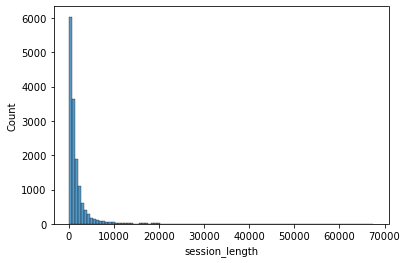

In [16]:
sns.histplot(listen_group_df['session_length'], bins=100)

<AxesSubplot:xlabel='session_length', ylabel='Count'>

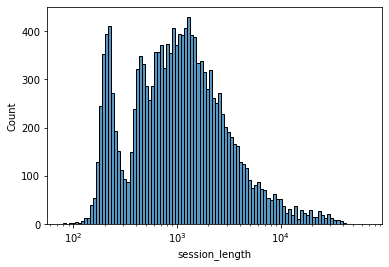

In [17]:
sns.histplot(listen_group_df['session_length'], bins=100, log_scale=True)

<AxesSubplot:xlabel='number_of_songs', ylabel='Count'>

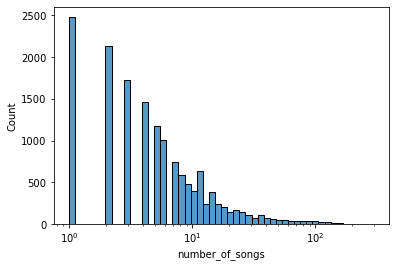

In [18]:
sns.histplot(listen_group_df['number_of_songs'], bins=50, log_scale=True)

<AxesSubplot:xlabel='track_duration', ylabel='Count'>

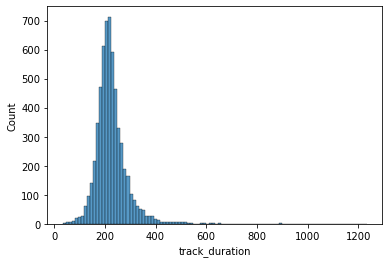

In [19]:
sns.histplot((fourth_merge[['track_name_x', 'artist_name_x', 'track_duration']].drop_duplicates()['track_duration'] / 1000), bins=100)

In [124]:
listen_group_df.to_csv("listen_group.csv")

In [125]:
fourth_merge.to_csv("fourth_merge.csv")

In [3]:
fourth_merge = pd.read_csv("fourth_merge.csv")
listen_group_df = pd.read_csv("listen_group.csv")

In [4]:
listen_group_df['session_start_date'] = pd.to_datetime(listen_group_df['session_start_date'])
listen_group_df['start_of_last_song_date'] = pd.to_datetime(listen_group_df['start_of_last_song_date'])
listen_group_df['session_end_date'] = pd.to_datetime(listen_group_df['session_end_date'])

In [5]:
fourth_merge['date'] = pd.to_datetime(fourth_merge['date'])

In [6]:
listen_group_df = listen_group_df.set_index("session_id")

In [25]:
fourth_merge

Unnamed: 0                   track_name_x        artist_name_x  \
0                0               Bullets and Guns       Them Terribles   
1                1                     The Anthem       Good Charlotte   
2                2                     Painkiller         Judas Priest   
3                3                 Out of My Head  Theory of a Deadman   
4                4                  Cupid Shuffle                Cupid   
...            ...                            ...                  ...   
128343      128343                Procrastinating         Stellar Kart   
128344      128344     Push Push (Lady Lightning)          Bang Camaro   
128345      128345  Beach Bones (Feat. Ryan Ross)            More Amor   
128346      128346                    Canned Heat           Jamiroquai   
128347      128347                     Can't Help            Parachute   

       artist_name_merge                date                   track_name_y  \
0          themterribles 2013-09-07 10:51:10               Bullets and Guns   
1          goodcharlotte 2013-09-07 10:53:36                     The Anthem   
2            judaspriest 2013-09-07 10:56:31                     Painkiller   
3       theoryofadeadman 2013-09-07 11:02:49                 Out of My Head   
4                  cupid 2013-09-07 11:05:10                  Cupid Shuffle   
...                  ...                 ...                            ...   
128343       stellarkart 2020-12-17 00:32:43                Procrastinating   
128344        bangcamaro 2020-12-17 00:41:28     Push Push (Lady Lightning)   
128345          moreamor 2020-12-17 00:46:10  Beach Bones (feat. Ryan Ross)   
128346        jamiroquai 2020-12-17 00:49:36                    Canned Heat   
128347         parachute 2020-12-17 00:55:08                     Can't Help   

              artist_name_y                         album_name  \
0            Them Terribles             Rock, Paper, Terribles   
1            Good Charlotte         The Young and The Hopeless   
2              Judas Priest                         Painkiller   
3       Theory of a Deadman  The Truth Is... (Special Edition)   
4                     Cupid                  Time For A Change   
...                     ...                                ...   
128343         Stellar Kart        We Can't Stand Sitting Down   
128344          Bang Camaro                        Bang Camaro   
128345            More Amor      Beach Bones (feat. Ryan Ross)   
128346           Jamiroquai                        Synkronized   
128347            Parachute                         Can't Help   

                      album_id album_release_date  ...  speechiness  \
0       3Nc9E7ZKx8WqGqUbNRuV3r         2007-01-01  ...       0.2480   
1       5CTygC3aONv7l0klY4k3hc         2002-10-04  ...       0.1260   
2       7LgrhuKnAXpNEv8qzcVd2t         1990-09-26  ...       0.1600   
3       2JUpjRRxWKUZwVwY9sTXS1         2011-07-08  ...       0.0354   
4       1tDyAU95D65Shy34JxsQCu         2007-09-11  ...       0.2370   
...                        ...                ...  ...          ...   
128343  4E3hrnhsgHifQlL83tu57M         2006-07-25  ...       0.0424   
128344  2EW0qzRe2ntiYBerUAgJqr         2007-01-01  ...       0.0948   
128345  2yIHW7YYYhWBihGAQ984aI         2012-07-01  ...       0.0337   
128346  0rfXEWU67NngRYE58q1aMO         1999-06-08  ...       0.1250   
128347  0Fy31rd6aBdfrF3M4N09rb         2013-01-01  ...       0.0414   

       instrumentalness  acousticness liveness valence    tempo  \
0              0.000017      0.034400   0.0684   0.532  153.943   
1              0.000000      0.006660   0.1390   0.893  177.751   
2              0.084700      0.000195   0.2680   0.101  103.160   
3              0.000000      0.003270   0.3800   0.466  171.716   
4              0.000000      0.191000   0.2000   0.861   71.774   
...                 ...           ...      ...     ...      ...   
128343         0.000000      0.000066   0.3930   0.713 

In [20]:
fig = px.histogram(listen_group_df, x="session_length", log_x=True)
# fig.write_html("./session_log_histogram.html", include_plotlyjs="cdn")

In [21]:
fig

<AxesSubplot:xlabel='number_of_songs', ylabel='Count'>

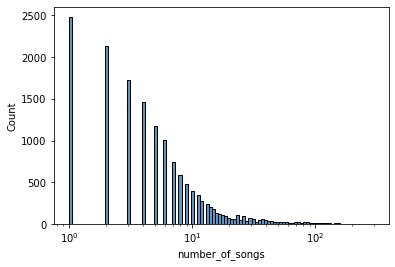

In [7]:
sns.histplot(listen_group_df['number_of_songs'], bins=100, log_scale=True)

In [45]:
fig = px.histogram(song_series, labels={"value": "Number of Songs in Session"})
fig.update_layout({
    "plot_bgcolor": "rgba(0,0,0,0)",
    "paper_bgcolor": "rgba(0,0,0,0)"
})
fig.write_html("./session_song_numbers_histogram.html", include_plotlyjs="cdn")
fig

In [42]:
temp_df = fourth_merge[['track_name_x', 'artist_name_x', 'track_duration']].set_index(["track_name_x", "artist_name_x"]).drop_duplicates()
temp_df = temp_df['track_duration'] / (1000)
fig = px.histogram(temp_df, labels={"value": "Song Length (seconds)"})
fig.update_layout({
    "plot_bgcolor": "rgba(0,0,0,0)",
    "paper_bgcolor": "rgba(0,0,0,0)"
})
fig.write_html("./song_length_histogram.html", include_plotlyjs="cdn")
fig

In [22]:
import scipy

In [24]:
num_bins = 100
song_series = listen_group_df['number_of_songs'].sort_values()
# song_series = fourth_merge[['track_name_x', 'artist_name_x', 'track_duration']].drop_duplicates()['track_duration'] / 1000
song_series = song_series.loc[~song_series.isna()]
series_size = len(song_series)
#Generate a histogram using numpy
quantities, bin_bounds = np.histogram(song_series, bins=num_bins)
#Enumerate the distributions we'll check for goodness of fit
distributions = ['expon', 'norm', 'gamma', 'chi2', 'invgauss', 'beta', 'weibull_max', 'weibull_min', 'pareto', 'loggamma', 'lomax', 'erlang', 'f', 'frechet_l', 'frechet_r', 'genpareto', 'halfcauchy', 'halfgennorm', 'invgamma', 'invweibull', 'lognorm', 'loglaplace', 'reciprocal', 'wald', 'gilbrat', 'halflogistic', 'halfnorm', 'kappa4', 'kappa3', 'uniform', 'johnsonsb', 'johnsonsu', 'fatiguelife', 'crystalball', 'bradford', 'betaprime', 'alpha', 'anglit', 'argus', 'burr', 'burr12', 'chi', 'exponnorm', 'exponweib', 'exponpow', 'hypsecant', 'ksone', "recipinvgauss", 'fisk', 'pearson3', 'rdist', 'rayleigh', 'dgamma', 'dweibull', 'vonmises', 't', 'gengamma', 'gennorm', 'genextreme', 'genexpon', 'cauchy', 'gausshyper', 'levy', 'logistic', 'lognorm', 'maxwell', 'mielke', 'moyal', 'nakagami', 'ncx2', 'ncf', 'nct']
#This will contain a 2xn list which will be turned into a DataFrame near the end
chi_squared_statistic_series = []

#Iterate over each distribution string listed above, use getattr to grab the appropriate object in scipy.stats, find the appropriate parameters from a fit, then generate a cdf array
#using the bounds obtained from the generation of the histogram above
for dist_str in distributions:
    dist = getattr(scipy.stats, dist_str)
    params = dist.fit(song_series)
    cdf_array = dist.cdf(bin_bounds, *params)

    chi_squared_statistic = 0
    #Enumerate so we can obtain the next bin as well
    for i, current_bin in enumerate(bin_bounds):
        #Break to prevent a keyerror
        if i == num_bins - 1:
            break
        
        #Calculate expected value, if expected value is 0 we don't have a way to deal with the inevitable nan so we just skip it
        next_bin = bin_bounds[i + 1]
        expected_value = series_size * (cdf_array[i + 1] - cdf_array[i])
        if expected_value == 0:
            continue
        
        #Calculate the chi squared statistic
        chi_squared_statistic += (quantities[i] - expected_value) ** 2 / expected_value
    if chi_squared_statistic > 0:
        #Once the loop is done, append the distribution string with the chi squared statistic to the list that will eventually become a dataframe
        chi_squared_statistic_series.append([dist_str, chi_squared_statistic])
#Set up the DataFrame and name the columns, then set index and sort by value to display the "closest fit"
dist_df = pd.DataFrame(chi_squared_statistic_series, columns=["Distribution", "Value"])
dist_df.set_index("Distribution").sort_values("Value")

Value
Distribution              
reciprocal    2.782987e+02
ncf           3.211248e+02
betaprime     5.315000e+02
nct           5.443732e+02
invgamma      5.915992e+02
...                    ...
maxwell       7.146691e+12
loggamma      1.636362e+13
crystalball   1.790465e+13
norm          1.792293e+13
gamma         1.880510e+14

[72 rows x 1 columns]

<AxesSubplot:>

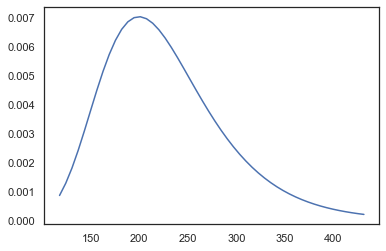

In [215]:
d_str = "genextreme"
d_ist = getattr(scipy.stats, d_str)
d_param = d_ist.fit(song_series)
samp_dist = d_ist(*d_param)
x = np.linspace(samp_dist.ppf(0.01), samp_dist.ppf(.99))
sns.lineplot(x=x, y=samp_dist.pdf(x))

In [221]:
[x, samp_dist.cdf(x)]

[array([118.14007225, 124.53120714, 130.92234204, 137.31347693,
        143.70461183, 150.09574672, 156.48688162, 162.87801651,
        169.26915141, 175.6602863 , 182.0514212 , 188.44255609,
        194.83369099, 201.22482588, 207.61596078, 214.00709567,
        220.39823057, 226.78936546, 233.18050036, 239.57163525,
        245.96277015, 252.35390504, 258.74503994, 265.13617483,
        271.52730973, 277.91844462, 284.30957952, 290.70071441,
        297.09184931, 303.48298421, 309.8741191 , 316.265254  ,
        322.65638889, 329.04752379, 335.43865868, 341.82979358,
        348.22092847, 354.61206337, 361.00319826, 367.39433316,
        373.78546805, 380.17660295, 386.56773784, 392.95887274,
        399.35000763, 405.74114253, 412.13227742, 418.52341232,
        424.91454721, 431.30568211]),
 array([0.01      , 0.0167788 , 0.02658417, 0.04002253, 0.05757466,
        0.07953678, 0.1059852 , 0.13676818, 0.17152326, 0.20971419,
        0.25067986, 0.29368714, 0.3379813 , 0.38282933, 0.

<AxesSubplot:xlabel='track_duration', ylabel='Count'>

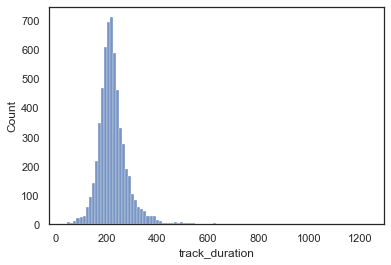

In [200]:
sns.histplot(song_series, bins=100)

In [47]:
length_series = fourth_merge.loc[~fourth_merge['track_duration'].isna(), ['track_name_x', 'artist_name_x', 'track_duration']].drop_duplicates()['track_duration'] / 1000

In [135]:
scipy.stats.chi2.ppf(.95, 99)

123.2252214533618

In [48]:
#Create the distribution for the song length
length_dist =   scipy.stats.genextreme
length_params = length_dist.fit(length_series)
length_dist =   length_dist(*length_params)

#Create the distribution for the number of songs in a session
count_dist =    scipy.stats.betaprime
count_params =  count_dist.fit(song_series)
count_dist =    count_dist(*count_params)

#Generate 10,000 random numbers
rands =     np.random.rand(10000)
#Use the series of random numbers generated above to generate an array of integers denoting the number of songs played in a session
counts =    np.floor(count_dist.ppf(rands)).astype(int)
#Turn all values of 0 into 1
counts[counts == 0] = 1

#Then, generate using the song length distribution a random value for each song in the session and add up the lengths.
lengths = pd.Series([[y.sum(), y.mean()] for y in [length_dist.ppf(np.random.rand(i))] for i in counts])
means   = pd.Series([length_dist.ppf(np.random.rand(i)).mean() for i in counts])

In [59]:
dists = pd.DataFrame([lengths, means, counts]).T
dists.columns = ["sums", "means", "counts"]
dists.corr()

sums     means    counts
sums    1.000000 -0.002687  0.999804
means  -0.002687  1.000000 -0.002736
counts  0.999804 -0.002736  1.000000

In [50]:
from matplotlib import pyplot as plt

In [39]:
px.histogram(listen_group_df['session_length'])

[Text(0.5, 0, 'session_length')]

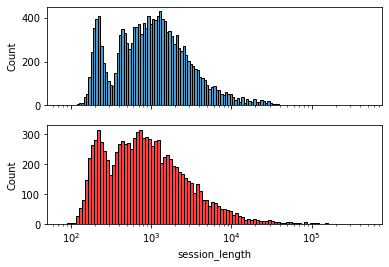

In [51]:
f, axes = plt.subplots(2,1, sharex=True)
sns.histplot(listen_group_df['session_length'], bins=100, log_scale=True, ax=axes[0])
sns.histplot(lengths, bins=100, log_scale=True, ax=axes[1], color="red")
axes[1].set(xlabel="session_length")

In [52]:
lengths

0       2016.433375
1       1451.780676
2        629.679918
3        253.082665
4        696.918040
           ...     
9995     450.890799
9996     385.895170
9997    6820.909167
9998    1431.299802
9999     873.783552
Length: 10000, dtype: float64

[Text(0.5, 0, 'session_length')]

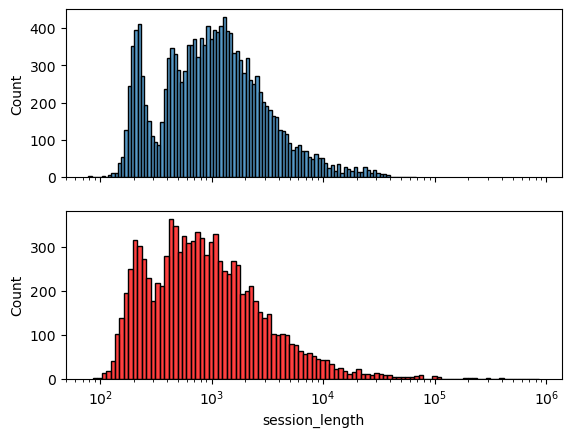

In [376]:
f, axes = plt.subplots(2,1, sharex=True)
sns.histplot(listen_group_df['session_length'], bins=100, log_scale=True, ax=axes[0])
sns.histplot(lengths, bins=100, log_scale=True, ax=axes[1], color="red")
axes[1].set(xlabel="session_length")

<AxesSubplot:ylabel='Count'>

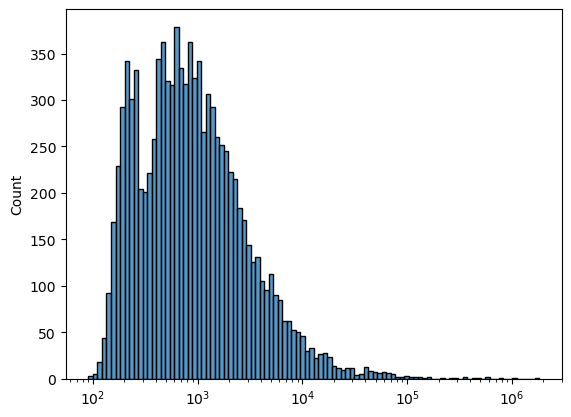

In [340]:
sns.histplot(lengths, bins=100, log_scale=True)

In [233]:
listen_group_df['mean_song_length'] = listen_group_df['session_length'] / listen_group_df['number_of_songs']

<AxesSubplot:xlabel='number_of_songs'>

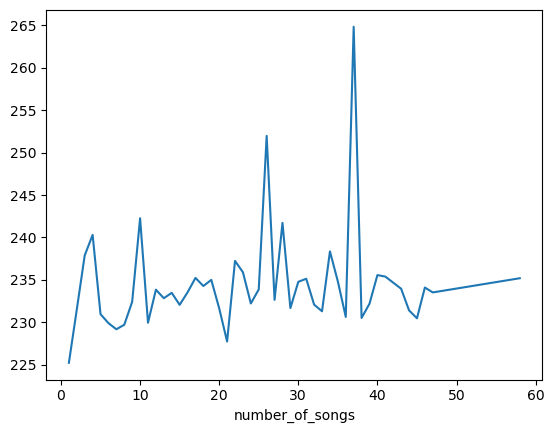

In [370]:
song_length_df = listen_group_df.groupby("number_of_songs").agg({"mean_song_length": "mean", "session_length": "count"})
song_length_df.loc[song_length_df['session_length'] > 10, 'mean_song_length'].plot()

In [264]:
listen_group_df.corr()

track_duration  number_of_songs  session_length  \
track_duration          1.000000         0.018573        0.038172   
number_of_songs         0.018573         1.000000        0.973922   
session_length          0.038172         0.973922        1.000000   
mean_song_length        0.110474         0.004272        0.195717   

                  mean_song_length  
track_duration            0.110474  
number_of_songs           0.004272  
session_length            0.195717  
mean_song_length          1.000000

In [371]:
length_params

(0.016042324845494546, 199.0969707932207, 52.364007666620964)

In [372]:
length_dist.mean()

228.503469763192

In [374]:
(length_dist.mean() - length_params[1]) / .5772156649015328606

50.94542778042544

In [377]:
path = "C:\\Users\\CesarPC\\Downloads\\archive"

In [379]:
big_song_df = pd.read_csv(f"{path}\\data.csv")

In [381]:
pd.read_csv(f"{path}\\data_w_genres.csv").columns

Index(['genres', 'artists', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
       'tempo', 'valence', 'popularity', 'key', 'mode', 'count'],
      dtype='object')

<AxesSubplot:xlabel='duration_ms', ylabel='Count'>

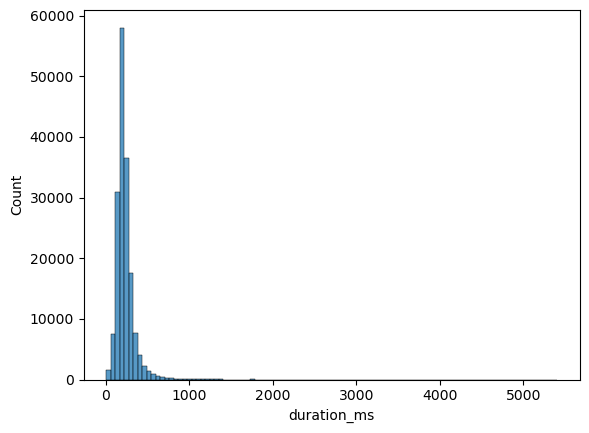

In [386]:
sns.histplot(big_song_df['duration_ms'] / 1000, bins=100)

In [387]:
length_params

(0.016042324845494546, 199.0969707932207, 52.364007666620964)

In [397]:
new_dist = scipy.stats.genextreme
new_params = new_dist.fit(big_song_df.loc[(big_song_df['duration_ms'] < 1000000) & (big_song_df['duration_ms'] > 1000 * 30), 'duration_ms'] / 1000)
new_params

(-0.03340010060109687, 185.24687998445688, 69.79401459597369)

In [395]:
big_song_df.sort_values('duration_ms')

valence  year  acousticness  \
78141   0.000000  1949      0.000000   
22399   0.000000  1938      0.000000   
22464   0.000000  1938      0.000000   
142097  0.000000  1949      0.000000   
79007   0.000000  1953      0.990000   
...          ...   ...           ...   
106689  0.000010  2010      0.932000   
55239   0.000010  2010      0.932000   
168377  0.029300  2009      0.000385   
138618  0.000537  2009      0.975000   
107341  0.000000  2013      0.111000   

                                                  artists  danceability  \
78141                                   ['Sarah Vaughan']        0.0000   
22399                                   ['Benny Goodman']        0.0000   
22464                                   ['Benny Goodman']        0.0000   
142097                                  ['Sarah Vaughan']        0.0000   
79007   ['Sergei Rachmaninoff', 'Arthur Rubinstein', '...        0.0000   
...                                                   ...           ...   
106689                ['One Hour Gulf Coast Ocean Waves']        0.0797   
55239                           ['Ocean Waves For Sleep']        0.0797   
168377              ['Lightning, Thunder and Rain Storm']        0.1160   
138618                                ['Sounds for Life']        0.1530   
107341                                  ['Sound Dreamer']        0.0000   

        duration_ms    energy  explicit                      id  \
78141          5108  0.000000         0  0hr9kRUi2X4MXc72A4VxG4   
22399          5991  0.000000         0  3IcXTeq9O2dpsSXsDj9naH   
22464          6362  0.000000         0  523qs4UcGlQ6ycdha1VGqs   
142097         6467  0.000000         0  3lRVIn6D6EUbvkOgPZAU1H   
79007          8853  0.722000         0  0MMpXuAkKfU4poBGLwHXUI   
...             ...       ...       ...                     ...   
106689      4120258  0.995000         0  31j000tQs35leo6djoDFSM   
55239       4120258  0.995000         0  1saXdvEAafdRzUphXBzSHg   
168377      4269407  0.338000         0  7dYf0CsWHDLvlP6HJPs3zO   
138618      4270034  0.079200         0  605JTCltCe1IcqrGXQ294K   
107341      5403500  0.000099         0  7foc25ig7dibxvULPU2kBG   

        instrumentalness  key  liveness  loudness  mode  \
78141             0.0000    0     0.000   -60.000     0   
22399             0.0000    0     0.000   -60.000     0   
22464             0.0000    0     0.000   -60.000     0   
142097            0.0000    0     0.000   -60.000     0   
79007             0.7920    2     0.447    -7.916     1   
...                  ...  ...       ...       ...   ...   
106689            0.5620    1     0.310   -17.379     1   
55239             0.5620    1     0.310   -17.379     1   
168377            0.0935    1     0.342   -36.638     1   
138618            1.0000   10     0.113   -23.962     0   
107341            0.3920    2     0.137   -21.669     1   

                                                     name  popularity  \
78141                                         Pause Track           0   
22399                                  Pause Track - Live           0   
22464                                  Pause Track - Live           0   
142097                                        Pause Track           0   
79007   Rhapsody on a Theme of Paganini, Op. 43: Intro...           0   
...                                                   ...         ...   
106689  Natural White Noise for Babies - Ocean Waves f...          57   
55239                               Ocean Waves for Sleep          56   
168377                       Midnight Thunderstorm Part 2          43   
138618                              Brown Noise for Sleep          42   
107341                           Brown Noise - 90 Minutes          50   

       release_date  speechiness    tempo  
78141          1949       0.0000    0.000  
22399          1938       0.0000    0.000  
22464          1938       0.0000    0.000  
142097         1949       0.0000    0.000  
79007          1

In [401]:
big_song_df.loc[big_song_df['id'].isin(fourth_merge['track_id'].drop_duplicates())]

valence  year  acousticness  \
6806      0.568  1956      0.383000   
6907      0.481  1956      0.782000   
7015      0.915  1957      0.452000   
7019      0.888  1957      0.755000   
7057      0.887  1957      0.708000   
...         ...   ...           ...   
169826    0.529  2016      0.011700   
169872    0.185  2017      0.000034   
170198    0.720  2018      0.323000   
170236    0.603  2018      0.869000   
170366    0.191  2019      0.640000   

                                              artists  danceability  \
6806                                ['Frank Sinatra']         0.577   
6907                                  ['Count Basie']         0.566   
7015    ['Louis Prima', 'Sam Butera & The Witnesses']         0.515   
7019                               ['Little Richard']         0.474   
7057                                 ['The Crickets']         0.607   
...                                               ...           ...   
169826                                   ['FLETCHER']         0.526   
169872                               ['Foo Fighters']         0.359   
170198                               ['Paulo Londra']         0.767   
170236                              ['Michael Bublé']         0.693   
170366                           ['Benjamin Martins']         0.320   

        duration_ms  energy  explicit                      id  \
6806         177400   0.306         0  2WaYW84yWij5NSCpgSeU2R   
6907         314267   0.313         0  5JZoHrIGklz4iUlUNjMBcs   
7015         141667   0.408         0  4tmy6FB76bR5eLmx0zO1mn   
7019         127427   0.608         0  507IFqPuG8mBQoKebfGG9t   
7057         122600   0.477         0  20UjAGdEjVb8DniNXvqHJy   
...             ...     ...       ...                     ...   
169826       228289   0.821         0  0fFYGwyzvRLQXwm5IMK4oE   
169872       323373   0.893         0  1wLQwg0mloy3yXjL0jPE0N   
170198       258639   0.709         0  6FyRXC8tJUh863JCkyWqtk   
170236       182667   0.257         0  7JEUg9KqmpdIE5Nbb9ss66   
170366       200346   0.256         0  7JrSIPcfkWhDzxWII8Jz7V   

        instrumentalness  key  liveness  loudness  mode  \
6806             0.00000    9    0.1800   -11.559     1   
6907             0.00145    5    0.0657   -14.823     0   
7015             0.00000    8    0.0682   -11.960     1   
7019             0.00000    5    0.0928    -5.139     1   
7057             0.00000    9    0.2530   -12.904     1   
...                  ...  ...       ...       ...   ...   
169826           0.00000   11    0.0887    -5.242     1   
169872           0.09550    4    0.7510    -8.036     0   
170198           0.00000    1    0.0676    -4.470     1   
170236           0.00000    6    0.1100    -7.785     1   
170366           0.86200   10    0.1120   -17.980     1   

                                               name  popularity release_date  \
6806    You Make Me Feel So Young - Remastered 1998          67      1956-03   
6907                                Shiny Stockings          38         1956   
7015                            Pennies From Heaven          59         1957   
7019                    Long Tall Sally (The Thing)          62      1957-03   
7057                                     Maybe Baby          50   1957-01-01   
...                                             ...         ...          ...   
169826                                    War Paint          56   2016-09-30   
169872                                          Run          63   2017-09-15   
170198                                   Adan y Eva          73   2018-11-05   
170236                             Love You Anymore          68   2018-11-16   
170366                                Escaping Time          64   2019-10-21   

        speechiness    tempo  
6806         0.0427  125.166  
6907         0.0561  117.624  
7015         0.1940  185.767  
7019         0.0825  184.694  
7057         0.0333  136.614  
...             ...      ...  
169826       0.074

In [404]:
fourth_merge.loc[~fourth_merge['track_id'].isin(big_song_df['id'])]

track_name_x     artist_name_x artist_name_merge  \
0                        Bullets and Guns    Them Terribles     themterribles   
6                               Two Weeks  All That Remains    allthatremains   
8       Everybody Wants to Rule the World     JamisonParker     jamisonparker   
9                             Straight Up           Halifax           halifax   
12                (Don't Fear) The Reaper  Blue Öyster Cult    blueoystercult   
...                                   ...               ...               ...   
128343                    Procrastinating      Stellar Kart       stellarkart   
128344         Push Push (Lady Lightning)       Bang Camaro        bangcamaro   
128345      Beach Bones (Feat. Ryan Ross)         More Amor          moreamor   
128346                        Canned Heat        Jamiroquai        jamiroquai   
128347                         Can't Help         Parachute         parachute   

                      date                   track_name_y     artist_name_y  \
0      2013-09-07 10:51:10               Bullets and Guns    Them Terribles   
6      2013-09-07 11:29:59                      Two Weeks  All That Remains   
8      2013-09-07 11:40:12                            NaN               NaN   
9      2013-09-07 11:42:47                    Straight Up           Halifax   
12     2013-09-07 11:54:02        (Don't Fear) The Reaper  Blue Öyster Cult   
...                    ...                            ...               ...   
128343 2020-12-17 00:32:43                Procrastinating      Stellar Kart   
128344 2020-12-17 00:41:28     Push Push (Lady Lightning)       Bang Camaro   
128345 2020-12-17 00:46:10  Beach Bones (feat. Ryan Ross)         More Amor   
128346 2020-12-17 00:49:36                    Canned Heat        Jamiroquai   
128347 2020-12-17 00:55:08                     Can't Help         Parachute   

                            album_name                album_id  \
0               Rock, Paper, Terribles  3Nc9E7ZKx8WqGqUbNRuV3r   
6                             Overcome  5iFDyVeI2md9y62pObgnAf   
8                       Punk Goes 80's  4RlkqhjQNbSHg7yqeouypa   
9                       Punk Goes 80's  7eHSy7FkcFmXgVIiR858jg   
12      The Essential Blue Öyster Cult  6NNrQJ8ojvbfFzoUjjABo4   
...                                ...                     ...   
128343     We Can't Stand Sitting Down  4E3hrnhsgHifQlL83tu57M   
128344                     Bang Camaro  2EW0qzRe2ntiYBerUAgJqr   
128345   Beach Bones (feat. Ryan Ross)  2yIHW7YYYhWBihGAQ984aI   
128346                     Synkronized  0rfXEWU67NngRYE58q1aMO   
128347                      Can't Help  0Fy31rd6aBdfrF3M4N09rb   

       album_release_date  album_total_tracks  ... speechiness  \
0              2007-01-01                 7.0  ...      0.2480   
6                    2008                11.0  ...      0.0552   
8              2005-06-07                15.0  ...      0.0326   
9                    2005                15.0  ...      0.0763   
12                   1972                14.0  ...      0.0609   
...                   ...                 ...  ...         ...   
128343         2006-07-25                13.0  ...      0.0424   
128344         2007-01-01                12.0  ...      0.0948   
128345         2012-07-01                 1.0  ...      0.0337   
128346         1999-06-08                10.0  ...      0.1250   
128347         2013-01-01                 1.0  ...      0.0414   

        instrumentalness acousticness liveness  valence    tempo  \
0               0.000017     0.034400   0.0684   0.5320  153.943   
6               0.000075     0.002050   0.2590   0.5560  111.999   
8               0.040900     0.014200   0.0808   0.0626  180.026   
9               0.000002     0.000506   0.0724   0.6090  170.246   
12              0.002130     0.001270   0.3050   0.5590  141.162   
...                  ...          ...      ...      ...      ...   
128343          0.000000     0.000066   0.393

In [433]:
pop_df = fourth_merge.loc[~fourth_merge['track_popularity'].isna()].sort_values("track_popularity")[['track_name_x', 'artist_name_x', 'track_popularity', 'album_id']].drop_duplicates()
pop_df

track_name_x      artist_name_x  track_popularity  \
128347                       Can't Help          Parachute               0.0   
64544                            Stella       All Time Low               0.0   
64545               More Than a Feeling             Boston               0.0   
64552                   99 Red Balloons         Goldfinger               0.0   
64554                      Troublemaker          Olly Murs               0.0   
...                                 ...                ...               ...   
127721                          Circles        Post Malone              91.0   
96747                   Sweater Weather  The Neighbourhood              91.0   
95705                    Last Christmas              Wham!              91.0   
95708   All I Want for Christmas Is You       Mariah Carey              99.0   
120379                  Blinding Lights         The Weeknd              99.0   

                      album_id  
128347  0Fy31rd6aBdfrF3M4N09rb  
64544   7taSr2Mmle8wuLsE1KeNym  
64545   01OahkTPRCleDjobtRk7ST  
64552   1rkTHzLQnF0rEv21zHLhnl  
64554   1wfXnX9Nf6aBbHTNgtVsLI  
...                        ...  
127721  4g1ZRSobMefqF6nelkgibi  
96747   4xkM0BwLM9H2IUcbYzpcBI  
95705   6egzU9NKfora01qaNbvwfZ  
95708   61ulfFSmmxMhc2wCdmdMkN  
120379  4yP0hdKOZPNshxUOjY0cZj  

[5789 rows x 4 columns]

In [19]:
unique_index = fourth_merge.loc[~fourth_merge['speechiness'].isna()][['track_name_x', 'artist_name_x']].drop_duplicates()
analysis_df = fourth_merge.loc[unique_index.index, ["track_name_x", "artist_name_x", "danceability", "energy", "key", "loudness", "mode", "speechiness", "instrumentalness", "acousticness", "liveness", "valence", "tempo", "time_signature"]].set_index(["track_name_x", "artist_name_x"])
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = pca.fit_transform(analysis_df)

In [20]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
normalized_df = pd.DataFrame(min_max_scaler.fit_transform(analysis_df), columns=analysis_df.columns, index=analysis_df.index)

In [22]:
# from plotly import express as px
from sklearn.manifold import TSNE
# pca = PCA(n_components=3)
pca = TSNE(n_components=3)
X = pca.fit_transform(normalized_df)
test_df = pd.DataFrame(X, index=normalized_df.index)
test_df = test_df.reset_index()
test_df['idx'] = test_df['track_name_x'] + '||' + test_df['artist_name_x']
test_df = test_df[['idx', 0, 1, 2]]
test_df.columns = ["idx", "x", "y", "z"]
test_df['xyz'] = test_df['x'] + test_df['y'] + test_df['z']
px.scatter_3d(test_df, x="x", y="y", z="z", color="xyz", hover_name=test_df["idx"])

In [61]:
# from plotly import express as px
# from sklearn.manifold import TSNE
pca = PCA(n_components=2)
# pca = TSNE(n_components=2)
X = pca.fit_transform(normalized_df)
test_df = pd.DataFrame(X, index=normalized_df.index)
test_df = test_df.reset_index()
test_df['idx'] = test_df['track_name_x'] + '||' + test_df['artist_name_x']
test_df = test_df[['idx', 0, 1]]
test_df.columns = ["idx", "x", "y"]
test_df['xy'] = test_df['x'] + test_df['y']
px.scatter(test_df, x="x", y="y", color="xy", hover_name=test_df["idx"])

In [482]:
test_df = test_df.reset_index()
test_df['idx'] = test_df['track_name_x'] + '||' + test_df['artist_name_x']
test_df[['idx', 0, 1]].set_index('idx')

0         1
idx                                                                   
Bullets and Guns||Them Terribles                   28.717689 -1.824664
The Anthem||Good Charlotte                         52.542121 -2.576325
Painkiller||Judas Priest                          -22.065179 -2.579287
Out of My Head||Theory of a Deadman                46.504964 -1.962240
Cupid Shuffle||Cupid                              -53.443748 -3.062131
...                                                      ...       ...
First Day of My Life||Jillian Edwards             -35.394606  5.015165
Boogie Shoes - 45 Version||KC & The Sunshine Band  -5.786830  3.559396
Cómo Te Voy A Olvidar||Los Ángeles Azules         -42.188920 -0.903171
Mi Gente||J Balvin                                -20.256215 -2.500802
Right Girl||MAINE                                 -36.194646 -5.136000

[5750 rows x 2 columns]

In [23]:
def parse_clipboard():
    clipboard_df = pd.read_clipboard(header=None)
    clipboard_df = clipboard_df[0].str[31:].to_frame()
    clipboard_df.columns = ["track_id"]
    return start_building_db(clipboard_df)

In [81]:
clipboard_df = pd.read_clipboard(header=None)
clipboard_df = clipboard_df[0].str[31:].to_frame()
clipboard_df.columns = ["track_id"]
clipboard_df

track_id
0     0prNGof3XqfTvNDxHonvdK
1     6T6D9CIrHkALcHPafDFA6L
2     1rfofaqEpACxVEHIZBJe6W
3     4l0Mvzj72xxOpRrp6h8nHi
4     15og0pCEcTFWEXOFKdcJlU
...                      ...
1090  4tJi4dodnpJ0MSKj2w6OkP
1091  05PFB9zqsoUv0vFpgGtyWq
1092  4uMvvCwqs046uxyJiFJTT1
1093  6TjP1C3sGQH1jBfzUXfcMg
1094  5BHWQ78pw9yIjIWa6p1z6G

[1095 rows x 1 columns]

In [24]:
pop_df = parse_clipboard()

In [25]:
rap_df = parse_clipboard()

In [26]:
rock_df = parse_clipboard()

In [27]:
electropop_df = parse_clipboard()

In [28]:
latin_df = parse_clipboard()

In [29]:
metal_df = parse_clipboard()

In [30]:
pop_punk_df = parse_clipboard()

In [31]:
genre_dfs   = [pop_df, rap_df, rock_df, latin_df, electropop_df, metal_df, pop_punk_df]
labels      = ["pop", "rap", "rock", "latin", "electropop", "metal", "pop_punk"]

In [34]:
labeled_df = pd.concat(genre_dfs, keys=labels).reset_index().rename(columns={"level_0": "genre"})[["genre", "track_id", *func_dict.metrics]].set_index("track_id")

In [35]:
labeled_df

genre  danceability  energy  key  loudness  mode  \
track_id                                                                      
0prNGof3XqfTvNDxHonvdK       pop         0.573   0.739    0    -5.740     1   
6T6D9CIrHkALcHPafDFA6L       pop         0.643   0.671    7    -7.450     1   
1rfofaqEpACxVEHIZBJe6W       pop         0.765   0.523    2    -4.333     1   
4l0Mvzj72xxOpRrp6h8nHi       pop         0.488   0.343    4    -8.985     1   
15og0pCEcTFWEXOFKdcJlU       pop         0.640   0.789    8    -4.891     1   
...                          ...           ...     ...  ...       ...   ...   
3IX3DBacud9x6KWo23PY66  pop_punk         0.362   0.839    8    -4.956     1   
1R9eK0NXBXFHDeBYIAWPIM  pop_punk         0.396   0.959    3    -3.252     0   
4jQfh94E6lZCebWgPGzvpw  pop_punk         0.456   0.838    0    -4.665     1   
0fS39bIa0jM3NfywM5cb4h  pop_punk         0.488   0.978    8    -4.240     1   
2O6NETmXPagFwFpvKKjtck  pop_punk         0.606   0.744    0    -5.436     1   

                        speechiness  instrumentalness  acousticness  liveness  \
track_id                                                                        
0prNGof3XqfTvNDxHonvdK       0.1290          0.000000      0.028500    0.1110   
6T6D9CIrHkALcHPafDFA6L       0.0842          0.017800      0.241000    0.1200   
1rfofaqEpACxVEHIZBJe6W       0.0300          0.000036      0.184000    0.1320   
4l0Mvzj72xxOpRrp6h8nHi       0.0436          0.000000      0.556000    0.2100   
15og0pCEcTFWEXOFKdcJlU       0.0644          0.000000      0.087500    0.1470   
...                             ...               ...           ...       ...   
3IX3DBacud9x6KWo23PY66       0.0648          0.000000      0.009020    0.2400   
1R9eK0NXBXFHDeBYIAWPIM       0.2790          0.000024      0.000047    0.1040   
4jQfh94E6lZCebWgPGzvpw       0.0468          0.000000      0.001440    0.0922   
0fS39bIa0jM3NfywM5cb4h       0.0470          0.000035      0.000273    0.0974   
2O6NETmXPagFwFpvKKjtck       0.0340          0.000005      0.058400    0.1410   

                        valence    tempo  time_signature  
track_id                                                  
0prNGof3XqfTvNDxHonvdK   0.4510   97.085               4  
6T6D9CIrHkALcHPafDFA6L   0.2970   96.924               4  
1rfofaqEpACxVEHIZBJe6W   0.3940  104.988               4  
4l0Mvzj72xxOpRrp6h8nHi   0.0978  102.819               4  
15og0pCEcTFWEXOFKdcJlU   0.7620   75.018               4  
...                         ...      ...             ...  
3IX3DBacud9x6KWo23PY66   0.4730  147.042               4  
1R9eK0NXBXFHDeBYIAWPIM   0.2310  179.822               4  
4jQfh94E6lZCebWgPGzvpw   0.6630  161.046               4  
0fS39bIa0jM3NfywM5cb4h   0.7760  136.010               4  
2O6NETmXPagFwFpvKKjtck   0.4380   91.997               4  

[6497 rows x 13 columns]

In [42]:
labeled_df2 = labeled_df.sample(frac=1).drop_duplicates(subset=func_dict.metrics, keep="first").reset_index()

In [43]:
labeled_df2.groupby("genre").nunique()

track_id  danceability  energy  key  loudness  mode  speechiness  \
genre                                                                          
electropop       775           406     463   12       740     2          451   
latin            975           427     462   12       905     2          557   
metal            621           349     283   12       585     2          407   
pop              951           431     520   12       901     2          538   
pop_punk         641           333     288   12       604     2          437   
rap              920           394     452   12       860     2          453   
rock            1139           485     551   12      1090     2          505   

            instrumentalness  acousticness  liveness  valence  tempo  \
genre                                                                  
electropop               524           654       428      518    745   
latin                    422           660       534      532    938   
metal                    454           543       406      415    616   
pop                      373           730       471      563    931   
pop_punk                 288           561       390      420    629   
rap                      302           677       488      533    899   
rock                     824           914       584      644   1132   

            time_signature  
genre                       
electropop               4  
latin                    4  
metal                    4  
pop                      4  
pop_punk                 4  
rap                      4  
rock                     4

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier

preprocessed = labeled_df2.groupby("genre").sample(n=621)
X = preprocessed.drop(columns=["genre"]).set_index("track_id")
min_max_scaler  = preprocessing.MinMaxScaler()
X               = pd.DataFrame(min_max_scaler.fit_transform(X), columns=X.columns, index=X.index)
y               = preprocessed['genre']
le              = LabelEncoder()
y               = le.fit_transform(y)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, stratify=y)

forest = RandomForestClassifier(n_estimators=250)
forest.fit(X_train, y_train)
score = forest.score(X_valid, y_valid)
score

0.5712643678160919

In [50]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(7)
])
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
model.fit(X_train, y_train, epochs=150, batch_size=10)
test_loss, test_acc = model.evaluate(X_valid, y_valid, verbose=2)

Epoch 1/150

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

348/348 [==============================] - 0s 1ms/step - loss: 1.9050 - accuracy: 0.2030
Epoch 2/150
348/348 [==============================] - 0s 1ms/step - loss: 1.6870 - accuracy: 0.2974
Epoch 3/150
348/348 [==============================] - 0s 1ms/step - loss: 1.5824 - accuracy: 0.3451
Epoch 4/150
348/348 [==============================] - 0s 1ms/step - loss: 1.5486 - accuracy: 0.3644
Epoch 5/150
348/348 [==============================] - 0s 1ms/step - loss: 1.5420 - accuracy: 0.3779
Epo

In [134]:
test_loss, test_acc = model.evaluate(X_valid, y_valid, verbose=2)

43/43 - 0s - loss: 1.2744 - accuracy: 0.5096


In [51]:
y_pred = model.predict_classes(X_valid)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [52]:
con_mat = tf.math.confusion_matrix(labels=y_valid, predictions=y_pred).numpy()
con_mat_2 = tf.math.confusion_matrix(labels=y_valid, predictions=forest.predict(X_valid)).numpy()

In [56]:
con_mat

array([[19, 17, 14, 45, 12,  4, 13],
       [ 1, 79,  0, 15,  2, 17, 10],
       [ 4,  0, 57,  1, 51,  1, 10],
       [ 6, 22,  2, 54, 15, 19,  7],
       [ 2,  7, 17,  9, 88,  0,  2],
       [ 0, 10,  1, 19,  0, 94,  0],
       [ 4, 19, 19,  3, 21,  2, 56]])

In [59]:
xx

array(['electropop', 'latin', 'metal', 'pop', 'pop_punk', 'rap', 'rock'],
      dtype=object)

In [60]:
import plotly.figure_factory as ff
xx = list(le.inverse_transform(range(7)))

con_text   = [[str(y) for y in x] for x in con_mat]
con_text_2 = [[str(y) for y in x] for x in con_mat_2]
fig = ff.create_annotated_heatmap(con_mat, x=xx, y=xx, annotation_text=con_text, colorscale="Viridis")
fig['data'][0]['showscale'] = True
fig.show()

In [62]:
fig = ff.create_annotated_heatmap(con_mat_2, x=xx, y=xx, annotation_text=con_text_2, colorscale="Viridis")
fig['data'][0]['showscale'] = True
fig.show()

In [186]:
metrics = ["danceability", "energy", "key", "loudness", "mode", "speechiness", "instrumentalness", "acousticness", "liveness", "valence", "tempo", "time_signature"]

In [64]:
min_max_scaler = preprocessing.MinMaxScaler()
Z = pd.DataFrame(min_max_scaler.fit_transform(analysis_df[func_dict.metrics]), columns=analysis_df[func_dict.metrics].columns, index=analysis_df[func_dict.metrics].index)

In [65]:
Z.head()

danceability    energy       key  \
track_name_x     artist_name_x                                           
Bullets and Guns Them Terribles           0.497637  0.961871  0.454545   
The Anthem       Good Charlotte           0.475651  0.938793  0.090909   
Painkiller       Judas Priest             0.410795  0.986956  0.090909   
Out of My Head   Theory of a Deadman      0.277784  0.837451  1.000000   
Cupid Shuffle    Cupid                    0.795537  0.580582  0.454545   

                                      loudness  mode  speechiness  \
track_name_x     artist_name_x                                      
Bullets and Guns Them Terribles       0.884207   0.0     0.243506   
The Anthem       Good Charlotte       0.911388   1.0     0.111472   
Painkiller       Judas Priest         0.878989   0.0     0.148268   
Out of My Head   Theory of a Deadman  0.893632   1.0     0.013420   
Cupid Shuffle    Cupid                0.874571   0.0     0.231602   

                                      instrumentalness  acousticness  \
track_name_x     artist_name_x                                         
Bullets and Guns Them Terribles               0.000017      0.034572   
The Anthem       Good Charlotte               0.000000      0.006692   
Painkiller       Judas Priest                 0.085469      0.000195   
Out of My Head   Theory of a Deadman          0.000000      0.003285   
Cupid Shuffle    Cupid                        0.000000      0.191959   

                                      liveness   valence     tempo  \
track_name_x     artist_name_x                                       
Bullets and Guns Them Terribles       0.057207  0.537912  0.619532   
The Anthem       Good Charlotte       0.129588  0.902931  0.756389   
Painkiller       Judas Priest         0.261841  0.102114  0.327612   
Out of My Head   Theory of a Deadman  0.376666  0.471178  0.721698   
Cupid Shuffle    Cupid                0.192126  0.870575  0.147193   

                                      time_signature  
track_name_x     artist_name_x                        
Bullets and Guns Them Terribles                 0.75  
The Anthem       Good Charlotte                 0.75  
Painkiller       Judas Priest                   0.75  
Out of My Head   Theory of a Deadman            0.75  
Cupid Shuffle    Cupid                          0.75

In [333]:
Z.iloc[np.argmax(Z.index.get_loc(("The Anthem")))].name[1]

'Good Charlotte'

In [386]:
le.inverse_transform(range(6))

array(['country', 'edm', 'hiphop', 'latin', 'pop', 'rock'], dtype=object)

In [66]:
mpreds = model.predict(Z)
fpreds  = forest.predict(Z)
def show_certainty(song, artist=None):
    if artist is not None:
        index_loc = Z.index.get_loc((song, artist))
        title = f"{song}, {artist}"
    else:
        index_loc = np.argmax(Z.index.get_loc(song))
        title = f"{song}, {Z.iloc[index_loc].name[1]}"
    return px.bar(x=le.inverse_transform(range(7)), y=mpreds[index_loc], title=title)

def show_certainty_f(song, artist=None):
    if artist is not None:
        index_loc = Z.index.get_loc((song, artist))
        title = f"{song}, {artist}"
    else:
        index_loc = np.argmax(Z.index.get_loc(song))
        title = f"{song}, {Z.iloc[index_loc].name[1]}"
    return px.bar(x=le.inverse_transform(range(7)), y=fpreds[index_loc], title=title)

In [393]:
fpreds

array([1, 0, 1, ..., 3, 2, 0])

In [68]:
show_certainty("Sucker")

In [368]:
analysis_df.loc["Sucker", metrics]

danceability  energy  key  loudness  mode  speechiness  \
artist_name_x                                                            
Jonas Brothers         0.842   0.734  1.0    -5.065   0.0       0.0588   

                instrumentalness  acousticness  liveness  valence    tempo  \
artist_name_x                                                                
Jonas Brothers               0.0        0.0427     0.106    0.952  137.958   

                time_signature  
artist_name_x                   
Jonas Brothers             4.0

In [365]:
pop_df.loc[pop_df['track_name'] == "Sucker", metrics]

danceability  energy  key  loudness  mode  speechiness  instrumentalness  \
21         0.842   0.734    1    -5.065     0       0.0588               0.0   

    acousticness  liveness  valence    tempo  time_signature  
21        0.0427     0.106    0.952  137.958               4

In [69]:
zy_pred = model.predict_classes(Z)
zz_pred = forest.predict(Z)

In [70]:
W = Z.copy()
W['genre_pred_ml'] = le.inverse_transform(zy_pred)
W['genre_pred_rf'] = le.inverse_transform(zz_pred)

In [72]:
W.loc[W['genre_pred_ml'] == 'pop'].sample(15)

danceability  \
track_name_x                                    artist_name_x                     
Delicate                                        Taylor Swift           0.757063   
Get Lucky                                       Karen Souza            0.480048   
Bang! Bang!                                     The Knux               0.706497   
Fearless                                        Taylor Swift           0.589975   
The Real Slim Shady                             Eminem                 0.975816   
Fall Together                                   The Temper Trap        0.535012   
Born This Way (The Country Road Version)        Lady Gaga              0.554798   
#SELFIE                                         The Chainsmokers       0.799934   
The Sun                                         Portugal. The Man      0.585578   
1977                                            Ana Tijoux             0.698802   
Goddess                                         Iggy Azalea            0.569089   
Cruel Summer                                    Taylor Swift           0.539409   
All the Time                                    Jeremih                0.674618   
Fifteen                                         Taylor Swift           0.543806   
What Goes Around.../...Comes Around (Interlude) Justin Timberlake      0.687809   

                                                                     energy  \
track_name_x                                    artist_name_x                 
Delicate                                        Taylor Swift       0.401979   
Get Lucky                                       Karen Souza        0.466196   
Bang! Bang!                                     The Knux           0.728081   
Fearless                                        Taylor Swift       0.713030   
The Real Slim Shady                             Eminem             0.659850   
Fall Together                                   The Temper Trap    0.624732   
Born This Way (The Country Road Version)        Lady Gaga          0.592623   
#SELFIE                                         The Chainsmokers   0.915715   
The Sun                                         Portugal. The Man  0.644799   
1977                                            Ana Tijoux         0.683932   
Goddess                                         Iggy Azalea        0.739118   
Cruel Summer                                    Taylor Swift       0.700989   
All the Time                                    Jeremih            0.438101   
Fifteen                                         Taylor Swift       0.649816   
What Goes Around.../...Comes Around (Interlude) Justin Timberlake  0.722061   

                                                                        key  \
track_name_x                                    artist_name_x                 
Delicate                                        Taylor Swift       0.818182   
Get Lucky                                       Karen Souza        0.545455   
Bang! Bang!                                     The Knux           0.181818   
Fearless                                        Taylor Swift       0.454545   
The Real Slim Shady                             Eminem             0.454545   
Fall Together                                   The Temper Trap    0.454545   
Born This Way (The Country Road Version)        Lady Gaga          1.000000   
#SELFIE                                         The Chainsmokers   0.000000   
The Sun                                         Portugal. The Man  0.181818   
1977                                            Ana Tijoux         0.818182   
Goddess                                         Iggy Azalea        0.090909   
Cruel Summer                                    Taylor Swift       0.818182   
All the Time                                    Jeremih            0.818182   
Fifteen                                         Taylor Swift       0.636364   
What Goes Around.../...Comes Around (Interlude)

In [250]:
labeled_df2 = labeled_df2.sample(frac=1).drop_duplicates(subset="track_id", keep="first")

In [90]:
pd.json_normalize(sp.user_playlists("thesoundsofspotify", offset=5500)['items'])

'url': 'https://i.scdn.co/im...   
26  [{'height': None, 'url': 'https://i.scdn.co/im...   
27  [{'height': None, 'url': 'https://i.scdn.co/im...   
28  [{'height': None, 'url': 'https://i.scdn.co/im...   
29  [{'height': None, 'url': 'https://i.scdn.co/im...   
30  [{'height': None, 'url': 'https://i.scdn.co/im...   
31  [{'height': None, 'url': 'https://i.scdn.co/im...   
32  [{'height': None, 'url': 'https://i.scdn.co/im...   
33  [{'height': None, 'url': 'https://i.scdn.co/im...   
34  [{'height': None, 'url': 'https://i.scdn.co/im...   
35  [{'height': None, 'url': 'https://i.scdn.co/im...   

                                               name primary_color  public  \
0                    The Needle / Taiwan - Emerging          None    True   
1                 The Needle / Taiwan - Underground          None    True   
2                             The Needle / Thailand          None    True   
3                   The Needle / Thailand - Current          None    True   
4                  The Needle / Thailand - Emerging          None    True   
5               The Needle / Thailand - Underground          None    True   
6                              The Needle / Tunisia          None    True   
7                    The Needle / Tunisia - Current          None    True   
8                               The Needle / Turkey          None    True   
9                     The Needle / Turkey - Current          None    True   
10                   The Needle / Turkey - Emerging          None    True   
11                The Needle / Turkey - Underground          None    True   
12                             The Needle / Ukraine          None    True   
13                   The Needle / Ukraine - Current          None    True   
14                  The Needle / Ukraine - Emerging          None    True   
15               The Needle / Ukraine - Underground          None    True   
16  The Needle / United Arab Emirates - Underground          None    True   
17                             The Needle / Uruguay          None    True   
18                   The Needle / Uruguay - Current          None    True   
19                  The Needle / Uruguay - Emerging          None    True   
20               The Needle / Uruguay - Underground          None    True   
21                The Needle / United Arab Emirates          None    True   
22      The Needle / United Arab Emirates - Current          None    True   
23     The Needle / United Arab Emirates - Emerging          None    True   
24                      The Needle / United Kingdom          None    True   
25            The Needle / United Kingdom - Current          None    True   
26           The Needle / United Kingdom - Emerging          None    True   
27        The Needle / United Kingdom - Underground          None    True   
28                                 The Needle / USA          None    True   
29                       The Needle / USA - Current          None    True   
30                      The Needle / USA - Emerging          None    True   
31                   The Needle / USA - Underground          None    True   
32                             The Needle / Vietnam          None    True   
33                   The Needle / Vietnam - Current          None    True   
34                  The Needle / Vietnam - Emerging          None    True   
35               The Needle / Vietnam - Underground          None    True   

                                          snapshot_id      type  \
0   MTM4MSw2OGViNTY1ZGZhY2ZjNmY1YWU3NDYwNTMyM2ZlZm...  playlist   
1   OTQxLDIwYjU5ODMxYTFhNDg5OTc2OWZkYzAxYTNjN2UyN2...  playlist   
2   NjI4LDJmNzZkNTg5OWZkZGQ3YjE4ZmRiOTYzYzAxNTkyND...  playlist   
3   NDUzLDYxN2I5OGJkYTMzZmJjOWQ3MmE2OTcyYTVkYjk3Mm...  playlist   
4   NDU5LDlmNTk3YWU4NmIwOTY1MjFlNWI5MTFjZTZjOTdkMG...  playlist   
5   NDUzLDJkOTNkNzdlZWIxOGIyYjYyMDk1NmNiMDQ2ODA4OG...  playlist   
6   MjY5LGI4MDVkZTQ2MjMwNWFmODI0NTg0NWM0ZGRjY2QwOT...  playlist   
7   MjU5

In [81]:
pd.json_normalize(return_json['items'])

playlist   
41  MjUyNSxlYzgzM2VmM2VkODI1NTU2ZWNlODc4ZjZjNDE0Zj...  playlist   
42  MjA0NixmNGE2MGI0ZWFjN2E2ODkyZDdlMmJmOWFiZDY0MG...  playlist   
43  NzYzLDdmZjE3NDI2ODU1OWExNmUwOTZkOTJiZjk3YmJkND...  playlist   
44  MjM3NixiNWM2MTU1NTczMGE2N2VjNDA0YTg3MzBjMDc2ZW...  playlist   
45  MTE2NSw2NmZlZDE4M2FlNTkzMzM2YTcwYzZhZDdhOTczNj...  playlist   
46  NTc2MywxYjBhNmFiN2JhODMxZjhmOTYzMTBlODY2MjcxZT...  playlist   
47  MzIwLDAyMDA0NzhkOGE3ZDAyZmUzOGUwY2U1MTdhZDQ5N2...  playlist   
48  NTM3OCxmMGE1NDhjNjQ5MWUyOGQzZDBlNWY4Zjk0YWFjNj...  playlist   
49  MTYwOCw2NzYxYTgxM2QwYjBhMTlkZDc3NmVjNTg1YzcyNj...  playlist   

                                        uri  \
0   spotify:playlist:69fEt9DN5r4JQATi52sRtq   
1   spotify:playlist:4ibx3N0OdTyTFZTRX1zEQQ   
2   spotify:playlist:7eybPwcFDYDzw1KYGqHiQo   
3   spotify:playlist:5d6HDkkTouObGKeQOg39gk   
4   spotify:playlist:2HUpNZLoYHe0Sa9dglqQOg   
5   spotify:playlist:5qQLE1iuD3CKOEXIb0fi7Z   
6   spotify:playlist:4GhzIuuhKmoxP4WMDukGhR   
7   spotify:playlist:0ORjwYMeNv9v441v6aHPa1   
8   spotify:playlist:2vLez030U00PBsuE2ug926   
9   spotify:playlist:5K5Bo0zrf3aoNvvDpGWxdK   
10  spotify:playlist:3vDCIJyWOCVTWbakvAtInY   
11  spotify:playlist:6tBMqR2dxCAe8PytK9cKcf   
12  spotify:playlist:4JaG749wpqi42yvjyRDvrU   
13  spotify:playlist:66hfhXEaNMA2NMncX5HatH   
14  spotify:playlist:59xLrarTtVR6GxK8aHETod   
15  spotify:playlist:6R9oHYFwTr01u6KsUW1vXb   
16  spotify:playlist:0iCuzAER8gjEjq9sdVkdx1   
17  spotify:playlist:3WkjlWImZ936rGAeweH93i   
18  spotify:playlist:1ZyQy6seivo6jkWyyTmwWs   
19  spotify:playlist:4v2etpAUyEX5sRicWn1IHC   
20  spotify:playlist:17buGP6jTSgqYoV4NwkMdX   
21  spotify:playlist:4yc86ER1kfXDvnKVEA7gKT   
22  spotify:playlist:7vyHBfRfPOT8Sxy87P5osJ   
23  spotify:playlist:3H6YJ47QOQiC74hZNVUU2f   
24  spotify:playlist:1f0ODk7IQYTRx3PxZlCeAy   
25  spotify:playlist:0rSDQ760FMUfBOFSAlnC8M   
26  spotify:playlist:23TcHEHll7Ds78hkaiohPx   
27  spotify:playlist:3OrDWwOHM2iQCwi5vIxlMJ   
28  spotify:playlist:1wsiIqm8FwH4FPW68LBFCr   
29  spotify:playlist:7dJlO6VYlCSlfxued1pqso   
30  spotify:playlist:6vjOsh6JeWFudKpQsOkYNP   
31  spotify:playlist:3pDfTmnPlLo7W0jO1HhllT   
32  spotify:playlist:7vgw73gZZ5gAIxK2emsSPU   
33  spotify:playlist:4jr1tvvMa8bYtXGQZPFn3T   
34  spotify:playlist:0FaMPDrv7VDRvfoPX9cNy9   
35  spotify:playlist:3sG0wNAvyO3tqubkuSIJ5E   
36  spotify:playlist:3VuEOL8OL3qW79EmaTSGKH   
37  spotify:playlist:7xrsyHt3RVeYJRSX5M4gzZ   
38  spotify:playlist:4iIcSDqi069piXRq7Y5x1C   
39  spotify:playlist:2F44c8g3v3EsAuPQvmHTIl   
40  spotify:playlist:0FmeDxPXfsozPAyWv9uFjL   
41  spotify:playlist:7kDOjv4aQuo4lFBDq9F6Rw   
42  spotify:playlist:562K7759REapjUDAJmEszO   
43  spotify:playlist:2umt4HDr7N53azdCC5YM1i   
44  spotify:playlist:6UjUqa407F8vrTz5gKg4Jd   
45  spotify:playlist:48uCDGE2YYjZsPSyhZXGP5   
46  spotify:playlist:1eXBFopkxdOaCJzPM6ljsL   
47  spotify:playlist:22Vw6zVm1ywaGcmSbbCJDe   
48  spotify:playlist:23e4SXJoxyNtQ3s2mSb5dx   
49  spotify:playlist:2W9yslxwwXvdsX1gpLETYD   

                                external_urls.spotify     owner.display_name  \
0   https://open.spotify.com/playlist/69fEt9DN5r4J...  The Sounds of Spotify   
1   https://open.spotify.com/playlist/4ibx3N0OdTyT...  The Sounds of Spotify   
2   https://open.spotify.com/playlist/7eybPwcFDYDz...  The Sounds of Spotify   
3   https://open.spotify.com/playlist/5d6HDkkTouOb...  The Sounds of Spotify   
4   https://open.spotify.com/playlist/2HUpNZLoYHe0...  The Sounds of Spotify   
5   https://open.spotify.com/playlist/5qQLE1iuD3CK...  The Sounds of Spotify   
6   https://open.spotify.com/playlist/4GhzIuuhKmox...  The Sounds of Spotify   
7   https://open.spotify.com/playlist/0ORjwYMeNv9v...  The Sounds of Spotify   
8   https://open.spotify.com/playlist/2vLez030U00P...  The Sounds of Spotify   
9   https://open.spotify.com/playlist/5K5Bo0zrf3ao...  The Sounds of Spotify   
10  https://open.spotify.com/playlist/3vDCIJyWOCVT...  The Sounds of Spotify   
11  https://open.spotify.c

In [91]:
len("The Sound of ")

13

In [101]:
pd.json_normalize(sp.playlist("0ORjwYMeNv9v441v6aHPa1", fields="tracks.items.track.id")['tracks']['items'])

track.id
0   3MTLncsF4tzTICc05bM034
1   5uO30wvPBNsDTiXUsKXlk1
2   0XguvJRZgqWguyBdrrRGxT
3   46NVdDmeMseP3CRW75f2RS
4   5OR65JDagDdrlVylEYwlzv
..                     ...
95  4ZZFGOd58jRTENyp67ScW2
96  5UHtLn7h4I4mjJbCJtlnvJ
97  2zN9gdZM7yCMUcT9XuBBaS
98  5nxc3FOCWsUsyECNwmeBuZ
99  0FiQFaAFGlhy38CkQZH2Eo

[100 rows x 1 columns]

In [129]:
response_json = sp.next(sp.playlist("0ORjwYMeNv9v441v6aHPa1", fields="tracks.items.track.id,tracks.next")['tracks'])

In [134]:
pd.json_normalize(response_json['items'])[["track.id"]]

track.id
0  4mHsVZBzeN6S2ZxA58m5K6
1  4BkM9xaBd7Qp6xwUa3SYgz
2  0tarjqnp72sMbgBc629nMp
3  4D1pdi2j1XdHsHlfSRYiDE
4  61zKLRNzmH8uI43WhNSrV5
5  0cHKqbG2NVH5yLeHC8gMGn
6  67SaEzEwJWXiq2Dbd3RXRo
7  7lSMCkStZxeaQWElndVI2y

In [12]:
def spotify_call(func):

    def wrapped_func(*args, **kwargs):
        try:
            result = func(*args, **kwargs)
        except SpotifyException as e:
            sleep_timer = e.headers['Retry-After']
            time.sleep(sleep_timer + .1)
            result = wrapped_func(*args, **kwargs)
        
        return result
    
    return wrapped_func

@spotify_call
def spotify_next(next_json):
    return sp.next(next_json)        
        
def retrieve_all_tracks_from_playlist(playlist_id):
    fields = "tracks.items.track.id, tracks.next"
    response_json = sp.playlist(playlist_id, fields=fields)['tracks']
    return_df = pd.json_normalize(response_json['items'])

    while response_json['next']:
        response_json = spotify_next(response_json)
        return_df = pd.concat([return_df, pd.json_normalize(response_json['items'])[["track.id"]]], ignore_index=True)
        try:
            response_json['next']
        except KeyError:
            break
    
    return return_df

@spotify_call
def retrieve_all_playlists_on_page(playlist_page_df):
    list_of_dfs = []
    for idx, [current_name, current_id] in playlist_page_df.iterrows():
        genre_name                  = current_name[len("The Sound of "):]
        playlist_df                 = retrieve_all_tracks_from_playlist(current_id)
        playlist_df['genre_name']   = genre_name
        list_of_dfs                += [playlist_df]
    
    return pd.concat(list_of_dfs, ignore_index=True)



def build_training_db():
    user = "thesoundsofspotify"
    base_len = len("The Sound of ")
    response_json = sp.user_playlists(user)
    response_df = pd.json_normalize(response_json['items'])
    initial_playlist_no = len(response_df)

    #Filter dataframe to only include 'The Sound of'
    response_df = response_df.loc[response_df['name'].apply(len) > base_len, ['name', 'id']]

    return_df   = retrieve_all_playlists_on_page(response_df)
    return_df.to_sql("Training_db", conn, if_exists="append")

    total_playlists = response_json['total']
    progress        = tqdm(total=total_playlists)
    progress.update(initial_playlist_no)

    while response_json['next']:
        response_json   = spotify_next(response_json)
        response_df     = pd.json_normalize(response_json['items'])
        no_on_page      = len(response_df)
        response_df     = response_df.loc[response_df['name'].apply(len) > base_len, ['name', 'id']]
        new_df          = retrieve_all_playlists_on_page(response_df)
        new_df.to_sql("Training_db", conn, if_exists="append")

        return_df       = pd.concat([return_df, new_df])
        progress.update(no_on_page)

        try:
            response_json['next']
        except KeyError:
            break
    
    return return_df




In [201]:
training_df = build_training_db()

100%|██████████| 5536/5536 [54:01<00:00,  2.32it/s]

In [189]:
test_df = pd.json_normalize(sp.user_playlists("thesoundsofspotify")['items'])
test_df = test_df.loc[test_df['name'].apply(len) > len("The Sound of "), ['name', 'id']]
retrieve_all_playlists_on_page(test_df)

ConnectionError: HTTPSConnectionPool(host='api.spotify.com', port=443): Max retries exceeded with url: /v1/users/thesoundsofspotify/playlists?limit=50&offset=0 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002A70E66FF10>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [206]:
training_df = training_df.iloc[:, :-1]

In [13]:
import sqlite3

In [14]:
conn = sqlite3.connect("last_fm.db")

In [21]:
genre_track_df = pd.read_sql("SELECT `TRACK.ID` AS track_id, GENRE_NAME FROM TRAINING_DB", conn)

In [24]:
genre_track_df

track_id             genre_name
0        2UEqfKWMx8SkbCQ9qLADW5             Everything
1        0WuuVfq5e2Zg1aaQzrJlxX             Everything
2        62bPGqh8IYBpVOzxIxkrXA             Everything
3        3MTLncsF4tzTICc05bM034             Everything
4        5LGWySQ2UWLh8oATzHI3nJ             Everything
...                         ...                    ...
1114143  5RBPhmnbILMVrHdl8pD2zp  Vietnam - Underground
1114144  6gBWxXAK6LTkGAy0062LoV  Vietnam - Underground
1114145  1GyxCY7wb80BOoqvkUD6R8  Vietnam - Underground
1114146  3E1zOhcFGZTrfdnhumSI4r  Vietnam - Underground
1114147  4cG7HUWYHBV6R6tHn1gxrl  Vietnam - Underground

[1114148 rows x 2 columns]

In [36]:
@spotify_call
def retrieve_tracks(input_list):
    return sp.tracks(input_list)

@spotify_call
def retrieve_features(input_list):
    return sp.audio_features(input_list)

def start_building_db(input_df):

    #Calculate the number of iterations to run for, minus one
    iterations = math.ceil(len(input_df) / 50) - 1
    #Create an empty list that will contain all the dataframes for each iteration called
    dfs = []

    for i in tqdm(range(iterations), total=iterations):
        #Slice the list of IDs that will be used. This ensures it will only ever be 50 at a time
        id_list = input_df['track_id'][50 * i : 50 * (i + 1)]
        #retrieve the track JSON for the given list of IDs

        track_json = retrieve_tracks(id_list)
        track_df = parse_multiple_tracks(track_json)

        feature_json = retrieve_features(id_list)
        feature_df = parse_multiple_features(feature_json)

        #Merge the two dataframes, using an inner merge to kick out any tracks which would have incomplete information
        merged_df = track_df.merge(feature_df, how="inner", left_on="track_id", right_on="id")

        dfs.append(merged_df)
    
    #Repeat the above process but for the final tracks, which can be up to 50. NOTE: THIS WILL CREATE DUPLICATES. THAT IS FINE
    final_tracks = input_df['track_id'][-50:]
    return_json = retrieve_tracks(final_tracks)
    track_df = parse_multiple_tracks(return_json)

    feature_json = retrieve_features(final_tracks)
    feature_df = parse_multiple_features(feature_json)

    merged_df = track_df.merge(feature_df, how="inner", left_on="track_id", right_on="id")
    dfs.append(merged_df)

    #Concatenate all the dataframes, ignore the index, and drop duplicates created in the last step
    return pd.concat(dfs, ignore_index=True).drop_duplicates(keep="first").reset_index(drop=True)

In [37]:
feature_df = start_building_db(genre_track_df)

100%|██████████| 22280/22280 [1:18:12<00:00,  4.75it/s]


In [30]:
from tqdm import tqdm

In [39]:
feature_df.to_sql("features", conn)

In [44]:
genre_feature_df = feature_df.merge(genre_track_df, on="track_id")

In [48]:
genre_feature_df.loc[genre_feature_df['artist_name'] == "Carly Rae Jepsen"]

album_name                album_id  \
257943                               Kiss  6SSSF9Y6MiPdQoxqBptrR2   
257944                               Kiss  6SSSF9Y6MiPdQoxqBptrR2   
257945                               Kiss  6SSSF9Y6MiPdQoxqBptrR2   
257946                               Kiss  6SSSF9Y6MiPdQoxqBptrR2   
257947                               Kiss  6SSSF9Y6MiPdQoxqBptrR2   
257948                               Kiss  6SSSF9Y6MiPdQoxqBptrR2   
257949                               Kiss  6SSSF9Y6MiPdQoxqBptrR2   
258168  Emotion (Deluxe Expanded Edition)  2oj3FG6fos7zAQJxLQGzou   
258169  Emotion (Deluxe Expanded Edition)  2oj3FG6fos7zAQJxLQGzou   
258170  Emotion (Deluxe Expanded Edition)  2oj3FG6fos7zAQJxLQGzou   
258171  Emotion (Deluxe Expanded Edition)  2oj3FG6fos7zAQJxLQGzou   
258172  Emotion (Deluxe Expanded Edition)  2oj3FG6fos7zAQJxLQGzou   
258173  Emotion (Deluxe Expanded Edition)  2oj3FG6fos7zAQJxLQGzou   
258174  Emotion (Deluxe Expanded Edition)  2oj3FG6fos7zAQJxLQGzou   
392057                   EMOTION SIDE B +  5DtDYAJmzCmazrf3eYBtgG   
392058                   EMOTION SIDE B +  5DtDYAJmzCmazrf3eYBtgG   
392059                   EMOTION SIDE B +  5DtDYAJmzCmazrf3eYBtgG   
392060                   EMOTION SIDE B +  5DtDYAJmzCmazrf3eYBtgG   
392061                   EMOTION SIDE B +  5DtDYAJmzCmazrf3eYBtgG   

       album_release_date  album_total_tracks       artist_name  \
257943         2012-01-01                  17  Carly Rae Jepsen   
257944         2012-01-01                  17  Carly Rae Jepsen   
257945         2012-01-01                  17  Carly Rae Jepsen   
257946         2012-01-01                  17  Carly Rae Jepsen   
257947         2012-01-01                  17  Carly Rae Jepsen   
257948         2012-01-01                  17  Carly Rae Jepsen   
257949         2012-01-01                  17  Carly Rae Jepsen   
258168               2015                  17  Carly Rae Jepsen   
258169               2015                  17  Carly Rae Jepsen   
258170               2015                  17  Carly Rae Jepsen   
258171               2015                  17  Carly Rae Jepsen   
258172               2015                  17  Carly Rae Jepsen   
258173               2015                  17  Carly Rae Jepsen   
258174               2015                  17  Carly Rae Jepsen   
392057         2017-09-13                   9  Carly Rae Jepsen   
392058         2017-09-13                   9  Carly Rae Jepsen   
392059         2017-09-13                   9  Carly Rae Jepsen   
392060         2017-09-13                   9  Carly Rae Jepsen   
392061         2017-09-13                   9  Carly Rae Jepsen   

                     artist_id  track_duration          track_name  \
257943  6sFIWsNpZYqfjUpaCgueju          193400       Call Me Maybe   
257944  6sFIWsNpZYqfjUpaCgueju          193400       Call Me Maybe   
257945  6sFIWsNpZYqfjUpaCgueju          193400       Call Me Maybe   
257946  6sFIWsNpZYqfjUpaCgueju          193400       Call Me Maybe   
257947  6sFIWsNpZYqfjUpaCgueju          193400       Call Me Maybe   
257948  6sFIWsNpZYqfjUpaCgueju          193400       Call Me Maybe   
257949  6sFIWsNpZYqfjUpaCgueju          193400       Call Me Maybe   
258168  6sFIWsNpZYqfjUpaCgueju          204763   I Really Like You   
258169  6sFIWsNpZYqfjUpaCgueju          204763   I Really Like You   
258170  6sFIWsNpZYqfjUpaCgueju          204763   I Really Like You   
258171  6sFIWsNpZYqfjUpaCgueju          204763   I Really Like You   
258172  6sFIWsNpZYqfjUpaCgueju          204763   I Really Like You   
258173  6sFIWsNpZYqfjUpaCgueju          204763   I Really Like You   
258174  6sFIWsNpZYqfjUpaCgueju          204763   I Really Like You   
392057  6sFIWsNpZYqfjUpaCgueju          207946  Cut To The Feeling   
392058  6sFIWsNpZYqfjUpaCgueju          207946  Cut To The Feeling   
392059  6sFIWsNpZYqfjUpaCgueju          207946  Cut To The Feeling   
392060  6sFIWsNpZYqfjUpaCgueju          207946  C

In [40]:
feature_df

album_name  \
0                                      Holst: The Planets   
1                       Cycle of the Sun (432hz) - Single   
2                                  青春時計 (Special Edition)   
3       Super Power Club: 8-Bit Tribute to Modern Rock...   
4                 The Best Song with 8D Effect (8D Tunes)   
...                                                   ...   
764424  True Beauty (Original Television Soundtrack), ...   
764425            hôm nay anh lại từ chối một lời tỏ tình   
764426                         Họ Gọi Anh Là Máy Bay Lag3   
764427                                  Họ Yêu Ai Mất Rồi   
764428                         Congratz To Me (feat. SOI)   

                      album_id album_release_date  album_total_tracks  \
0       5a5eHBTZbbHPSTnQo5PNKz         2006-07-28                  12   
1       6NYkKlhbJboTvPZIjOoM1H         2011-04-06                   1   
2       29JvLdMNnWQI5UGVB0iXoS         2017-04-11                   6   
3       18WSrQcRdR0z4qrTUJOpQd         2009-09-08                   7   
4       5MVRwpfVPvD3eII94UscTs         2019-03-11                  11   
...                        ...                ...                 ...   
764424  3LiiF0UIA8y7tgayZsbvp2         2021-01-14                   2   
764425  6KCXH2XqBk1cd73B9JoQox         2021-01-10                   2   
764426  1tMcr4xK0TXUf03Pdms5ZD         2021-01-18                   1   
764427  4dpS73EV3GboA1dxRIBrpz         2021-01-20                   1   
764428  7xFkwsZyHi4o6tYKICRZ6B         2021-01-08                   1   

               artist_name               artist_id  track_duration  \
0       Matthias Pintscher  69vvuLr29oiG02SjKP7fdO          475520   
1          Marc Van Mourik  7s9gWdUK3IXsvkQP58Es4H          576000   
2                    NGT48  4wZjP2p0Sm5EHM32uuAgGf          208466   
3         Super Power Club  5vGR79cM4EqZxXgvcExy7f          147586   
4                8d Effect  0r74RhZvEUGrewOuOG5W5w          153953   
...                    ...                     ...             ...   
764424        CHA NI (SF9)  3lrh60OfdaOmmHPQ15wHx8          263348   
764425                 Môi  4NDU73KRatunLsY5JuEAJV          224916   
764426            DJ Tom2k  5nPn46rZXQEDUh35MQGVhT          122723   
764427           Doãn Hiếu  52UlQPpkuAzH3BTfRDevYc          286725   
764428               RHOSY  3lL6jMbIkYzyxsXn3TU7GK          145129   

                                     track_name                track_id  \
0                                towards Osiris  2UEqfKWMx8SkbCQ9qLADW5   
1                      Cycle of the Sun (432hz)  0WuuVfq5e2Zg1aaQzrJlxX   
2                                          青春時計  62bPGqh8IYBpVOzxIxkrXA   
3                             Seven Nation Army  3MTLncsF4tzTICc05bM034   
4                             Havana - 8D Tunes  5LGWySQ2UWLh8oATzHI3nJ   
...                                         ...                     ...   
764424                                Starlight  7lV0M6ulaapTNZJzx8stw0   
764425  hôm nay anh lại từ chối một lời tỏ tình  1s7ILLJVe0UsmDRJD3gofa   
764426               Họ Gọi Anh Là Máy Bay Lag3  5RBPhmnbILMVrHdl8pD2zp   
764427                        Họ Yêu Ai Mất Rồi  6gBWxXAK6LTkGAy0062LoV   
764428               Congratz To Me (feat. SOI)  3E1zOhcFGZTrfdnhumSI4r   

        explicit  ...  key loudness  mode  speechiness  instrumentalness  \
0          False  ...    1  -28.571     1       0.0570          0.032300   
1          False  ...    9  -20.949     0       0.0290          0.941000   
2          False  ...    5   -4.087     0       0.0372          0.000000   
3          False  ...    4   -3.575     1       0.0545          0.915000   
4          False  ...    3  -13.522     1       0.0301          0.092100   
...          ...  ...  ...      ...   ...          ...               ...   
764424     False  ...    1   -5.773     1       0.0298          0.000000   
764425     False  ...    2  -10.318     1       0.0419          0.000002   
764426     

In [50]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit_transform(genre_track_df.set_index("track_id").sort_index())

MemoryError: Unable to allocate 23.0 GiB for an array with shape (1114048, 5534) and data type int32

In [1]:
import dask.dataframe as dd